In [3]:
import numpy as np
import pandas as pd
import scipy

from tqdm import tqdm

from sklearn.linear_model import LinearRegression

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
#plt.close("all")

# Scores

In [4]:
import scipy.stats

def Phi(x):
    return scipy.stats.norm.cdf(x)

def phi(x):
    return scipy.stats.norm.pdf(x)

In [5]:
def tr_norm_CRPS(mu, sigma, y):
    """CRPS for truncated normal distribution, see Wessel et al. 2024"""
    s = -mu/sigma
    alpha = -mu/sigma
    z = (y - mu)/sigma
    return sigma*(z*(2*(Phi(z)-Phi(alpha))/(1-Phi(alpha)) -1) + 2*phi(z)/(1-Phi(alpha)) - 1/np.sqrt(np.pi) * (1-Phi(np.sqrt(2)*alpha))/np.square(1-Phi(alpha)))

def tr_norm_twCRPS(mu, sigma, y, tau = 0):
    """twCRPS for truncated normal distribution, see Wessel et al. 2024"""
    alpha = -mu/sigma
    s = (tau - mu)/sigma
    z = (y-mu)/sigma

    twcrps_y_leq_tau = sigma * (-s*np.square((1-Phi(s))/(1-Phi(alpha))) + 2*phi(s) * (1-Phi(s))/np.square(1-Phi(alpha)) - 1/np.sqrt(np.pi) * (1-Phi(np.sqrt(2)*s))/np.square(1-Phi(alpha))) 
    twcrps_y_gre_tau = sigma*(-s*np.square((Phi(s)-Phi(alpha))/(1-Phi(alpha))) + z*(2*(Phi(z)-Phi(alpha))/(1-Phi(alpha)) -1) + 2/(1-Phi(alpha)) * (phi(z) - phi(s) * (Phi(s) - Phi(alpha))/(1-Phi(alpha))) - 1/np.sqrt(np.pi) * (1-Phi(np.sqrt(2)*s))/np.square(1-Phi(alpha)))

    return np.where(y <= tau, twcrps_y_leq_tau, twcrps_y_gre_tau)

def tr_norm_CRPS_weighted_sum(mu, sigma, y, tau = 0, gamma = 1):
    return tr_norm_CRPS(mu, sigma, y) + gamma*tr_norm_twCRPS(mu, sigma, y, tau)

def tr_norm_ll(mu, sigma, y):
    """log-likelihood for truncated normal distribution"""
    return np.log(sigma) + 0.5*np.square((y-mu)/sigma)

In [6]:
def tr_norm_nonproper_CRPS(mu, sigma, y, tau = 0):
    crps = tr_norm_CRPS(mu, sigma, y)
    return np.where(y > tau, crps, 0)

def tr_norm_nonproper_CRPS_hess_boers(mu, sigma, y, a = 0, b = 1):
    crps = tr_norm_CRPS(mu, sigma, y)
    weights = np.minimum(np.exp((y-a)/b), np.ones_like(y))
    return crps*weights

In [7]:
def L_CDF(x, mu, sigma):
    """CDF of logistic distribution"""
    return 1/(1+np.exp(-(x-mu)/sigma))

In [8]:
def tr_logistic_CRPS(mu, sigma, y):
    """CRPS for logistic distribution, see Allen et al. 2021"""
    p0 = L_CDF(0, mu, sigma)
    py = L_CDF(y, mu, sigma)
    
    return sigma*(np.log((1-p0)/(1-py)) - np.square(p0)/np.square(1-p0) * np.log(p0) - (1+p0)/(1-p0) * np.log(py) - 1/(1-p0))

def tr_logistic_twCRPS(mu, sigma, y, tau = 0):
    """twCRPS for logistic distribution, see Allen et al. 2021"""
    p0 = L_CDF(0, mu, sigma)
    py = L_CDF(y, mu, sigma)
    pt = L_CDF(tau, mu, sigma)
    
    twcrps_y_leq_tau = sigma*(pt-1-np.log(pt))/np.square(1-p0)
    twcrps_y_gre_tau = sigma*(np.log((1-pt)/(1-py)) - np.square(p0)/np.square(1-p0) * np.log(pt) - (1+p0)/(1-p0) * np.log(py) - (1-pt)/np.square(1-p0))

    return np.where(y <= tau, twcrps_y_leq_tau, twcrps_y_gre_tau)

def tr_logistic_CRPS_weighted_sum(mu, sigma, y, tau = 0, gamma = 1):
    return tr_logistic_CRPS(mu, sigma, y) + gamma*tr_logistic_twCRPS(mu, sigma, y, tau)

def tr_logistic_ll(mu, sigma, y):
    """log-likelihood for logistic distribution"""
    return (y-mu)/sigma + np.log(sigma*np.square(1+np.exp(-(y-mu)/sigma)))

In [9]:
def model(x, predictors):
    return x[0] + x[1]*predictors[:,0] + x[2]*predictors[:,2] + x[3]*predictors[:,3], np.exp(x[4] + x[5]*predictors[:,1] + x[6]*predictors[:,2] + x[7]*predictors[:,3])

def get_model_score(x, preds, y, score = tr_norm_CRPS, *args, **kwargs):
    return score(*model(x, preds), y, *args, **kwargs).mean()

def get_model_score_eval(x, preds, y, score = tr_norm_CRPS, *args, **kwargs):
    if x is None:
        return np.nan
    return score(*model(x, preds), y, *args, **kwargs).mean()

In [10]:
def do_optim(fun, x0, args, exp = ""):
    res_opt, method = _do_optim(fun, x0, args)
    
    if res_opt is not None:
        return res_opt, (method, "x0")
    
    x0 = np.array([0,1,0,0,0,1,0,0])
    res_opt, method = _do_optim(fun, x0, args)
    
    if res_opt is not None:
        return res_opt, (method, "01")
    
    for _ in range(5):
        x0 = np.random.rand(8)*2
        res_opt, method = _do_optim(fun, x0, args)

        if res_opt is not None:
            return res_opt, (method, "random")
        
    print(f"Optimization failed for experiment: {exp}")
    return None, (None, None)


In [11]:
def _do_optim(fun, x0, args):
    
    res_opt = scipy.optimize.minimize(fun = fun, x0 = x0, args = (args), method = "BFGS")
    if res_opt.success:
        return res_opt, "BFGS"
    
    res_opt = scipy.optimize.minimize(fun = fun, x0 = x0, args = (args), method = "Nelder-Mead")
    if res_opt.success:
        return res_opt, "Nelder-Mead"

    res_opt = scipy.optimize.minimize(fun = fun, x0 = x0, args = (args), method = "CG")
    if res_opt.success:
        return res_opt, "CG"
    
    return None, None

Helper for saving model results:

In [14]:
def get_eval_df(model, res_opt, x_test, y_test, tau, optim_meta, location, forecast_period, q_tau, distribution_type = "norm", **kwargs):
    if distribution_type == "norm":
        return pd.DataFrame({
            "Model type": model,
            "location": location,
            "forecast_period": forecast_period,
            "CRPS": get_model_score_eval(res_opt.x, x_test, y_test) if res_opt is not None else np.nan,
            "twCRPS": get_model_score_eval(res_opt.x, x_test, y_test, score = tr_norm_twCRPS, tau = tau) if res_opt is not None else np.nan,
            "optim": optim_meta[0],
            "x0": optim_meta[1],
            "quantile": q_tau,
            **kwargs
        }, index = [0])
    elif distribution_type == "logistic":
        return pd.DataFrame({
            "Model type": model,
            "location": location,
            "forecast_period": forecast_period,
            "CRPS": get_model_score_eval(res_opt.x, x_test, y_test, score = tr_logistic_CRPS) if res_opt is not None else np.nan,
            "twCRPS": get_model_score_eval(res_opt.x, x_test, y_test, score = tr_logistic_twCRPS, tau = tau) if res_opt is not None else np.nan,
            "optim": optim_meta[0],
            "x0": optim_meta[1],
            "quantile": q_tau,
            **kwargs
        }, index = [0])
    else:
        raise ValueError("Wrong distribution_type")

# Wind speed data

In [20]:
data = pd.read_csv("wind_speed_merged_forecast_all_stations_48h.csv", parse_dates = ["prediction_time", "forecast_reference_time"])
data.head()

issue_time prediction_time  location  ensemble_mean  altitude  \
0  2019-04-01      2019-04-03         0      13.231211      15.0   
1  2019-04-01      2019-04-03         1      13.799825      82.0   
2  2019-04-01      2019-04-03         2      14.230225      57.0   
3  2019-04-01      2019-04-03         3      13.601757      26.0   
4  2019-04-01      2019-04-03         4      14.047783       4.0   

  forecast_period forecast_reference_time  ensemble_sd  observation  
0          2 days              2019-04-01     2.067791          8.2  
1          2 days              2019-04-01     1.766573         13.4  
2          2 days              2019-04-01     2.255785         15.9  
3          2 days              2019-04-01     2.277136         15.9  
4          2 days              2019-04-01     1.448957         10.3

In [26]:
data = data.dropna()

In [27]:
data["forecast_period"] = (data.prediction_time - data.forecast_reference_time).dt.total_seconds()/(60*60)
data["tod"] = np.mod(data["forecast_period"].values, 24)
data["doy"] = data["prediction_time"].dt.dayofyear
data["doy_sin"] = np.sin(2*np.pi*data["doy"]/365.25)
data["doy_cos"] = np.cos(2*np.pi*data["doy"]/365.25)

In [28]:
len(data.location.unique())

124

## Test on stations

In [31]:
def get_data_one_loc(data, location, forecast_period = 48):
    data_one_loc = data[(data.location == location) & (data.forecast_period == forecast_period)]
    
    data_train = data_one_loc[data_one_loc.prediction_time.dt.year < 2021]
    data_test = data_one_loc[data_one_loc.prediction_time.dt.year >= 2021]
    
    x_train, y_train = data_train[["ensemble_mean", "ensemble_sd", "doy_sin", "doy_cos"]].values, data_train["observation"].values
    x_test, y_test = data_test[["ensemble_mean", "ensemble_sd", "doy_sin", "doy_cos"]].values, data_test["observation"].values
    
    return x_train, y_train, x_test, y_test

In [32]:
def get_data_mult_loc(data, locations, forecast_period = 48):
    data_one_loc = data[(data.location.isin(locations)) & (data.forecast_period == forecast_period)]
    
    data_train = data_one_loc[data_one_loc.prediction_time.dt.year < 2021]
    data_test = data_one_loc[data_one_loc.prediction_time.dt.year >= 2021]

    x_train, y_train = data_train[["ensemble_mean", "ensemble_sd", "doy_sin", "doy_cos"]].values, data_train["observation"].values
    x_test, y_test = data_test[["ensemble_mean", "ensemble_sd", "doy_sin", "doy_cos"]].values, data_test["observation"].values
    
    return x_train, y_train, x_test, y_test

# Semi-local estimation

## Get cluster assignment

In [43]:
feature_size = 24

quantiles = np.arange(1, feature_size +1, 1)/(feature_size + 1)

feature_set = np.zeros((len(data.location.unique()), feature_size))
for location in np.sort(data.location.unique()):
    x_train, y_train, x_test, y_test = get_data_one_loc(data, location, forecast_period = 48)
    forecast_errors = x_train[:, 0] - y_train 
    observations = y_train
    feature_set[location, :] = np.quantile(observations, quantiles)

C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

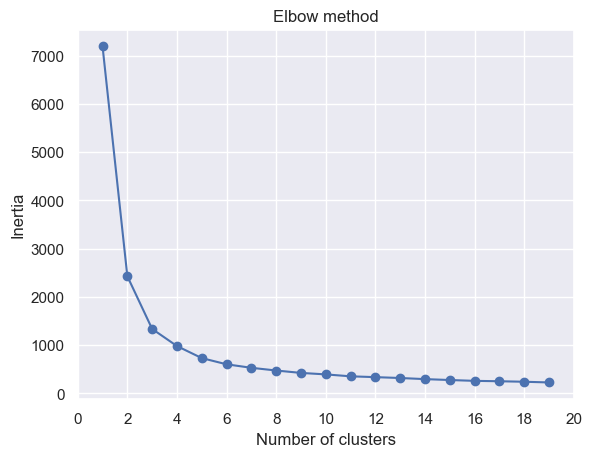

In [45]:
from sklearn.cluster import KMeans

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(feature_set)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.xticks(range(0, 22, 2))
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig("plots/kmeans_clusters.png", dpi=300, bbox_inches = "tight")
plt.show()


We choose k = 4 as this seems like the elbow.

In [74]:
n_clusters = 4
# Repeat a number of times to probe many initial conditions (even though in each fit already a number of different ones are fit)

clusters = []
inertias = []

for _ in range(50):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(feature_set)
    location_clusters = kmeans.labels_
    clusters.append([np.where(location_clusters == i)[0] for i in range(n_clusters)])
    inertias.append(kmeans.inertia_)


C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

In [90]:
clusters = clusters[np.argmin(inertias)]
clusters

[array([  9,  11,  15,  24,  33,  38,  39,  47,  49,  52,  53,  57,  69,
         71,  72,  73,  74,  75,  81,  83,  84,  90,  92,  94,  95, 105,
        110, 114, 117, 121], dtype=int64),
 array([  3,   5,   7,  13,  14,  16,  19,  20,  21,  25,  26,  31,  34,
         35,  43,  44,  48,  50,  56,  58,  60,  65,  67,  78,  80,  87,
         98, 100, 102, 103, 109, 111, 112, 115, 118], dtype=int64),
 array([  6,   8,  10,  12,  17,  22,  23,  27,  28,  29,  30,  36,  37,
         40,  41,  42,  51,  54,  55,  59,  62,  63,  64,  66,  70,  76,
         77,  82,  85,  86,  88,  89,  91,  93,  96,  97, 104, 106, 108,
        113, 116, 119, 120, 122], dtype=int64),
 array([  0,   1,   2,   4,  18,  32,  45,  46,  61,  68,  79,  99, 101,
        107, 123], dtype=int64)]

In [5]:
clusters = [np.array([  9,  11,  15,  24,  33,  38,  39,  47,  49,  52,  53,  57,  69,
         71,  72,  73,  74,  75,  81,  83,  84,  90,  92,  94,  95, 105,
        110, 114, 117, 121], dtype=np.int64),
 np.array([  3,   5,   7,  13,  14,  16,  19,  20,  21,  25,  26,  31,  34,
         35,  43,  44,  48,  50,  56,  58,  60,  65,  67,  78,  80,  87,
         98, 100, 102, 103, 109, 111, 112, 115, 118], dtype=np.int64),
 np.array([  6,   8,  10,  12,  17,  22,  23,  27,  28,  29,  30,  36,  37,
         40,  41,  42,  51,  54,  55,  59,  62,  63,  64,  66,  70,  76,
         77,  82,  85,  86,  88,  89,  91,  93,  96,  97, 104, 106, 108,
        113, 116, 119, 120, 122], dtype=np.int64),
 np.array([  0,   1,   2,   4,  18,  32,  45,  46,  61,  68,  79,  99, 101,
        107, 123], dtype=np.int64)]

n_clusters = 4

In [929]:
[len(x) for x in clusters]

[30, 35, 44, 15]

Visualize clusters:

In [50]:
location_clusters = np.empty((124,))
for i in range(4):
    location_clusters[clusters[i]] = i
location_clusters

array([3., 3., 3., 1., 3., 1., 2., 1., 2., 0., 2., 0., 2., 1., 1., 0., 1.,
       2., 3., 1., 1., 1., 2., 2., 0., 1., 1., 2., 2., 2., 2., 1., 3., 0.,
       1., 1., 2., 2., 0., 0., 2., 2., 2., 1., 1., 3., 3., 0., 1., 0., 1.,
       2., 0., 0., 2., 2., 1., 0., 1., 2., 1., 3., 2., 2., 2., 1., 2., 1.,
       3., 0., 2., 0., 0., 0., 0., 0., 2., 2., 1., 3., 1., 0., 2., 0., 0.,
       2., 2., 1., 2., 2., 0., 2., 0., 2., 0., 0., 2., 2., 1., 3., 1., 3.,
       1., 1., 2., 0., 2., 3., 2., 1., 0., 1., 1., 2., 0., 1., 2., 0., 1.,
       2., 2., 0., 2., 3.])

In [52]:
loc_clusters_df = pd.DataFrame({"location": list(range(124)), "cluster": location_clusters})
stations = pd.read_csv("stations_lat_lon.csv")
stations = stations.merge(loc_clusters_df, on = "location")
stations.cluster = stations.cluster.astype(str)

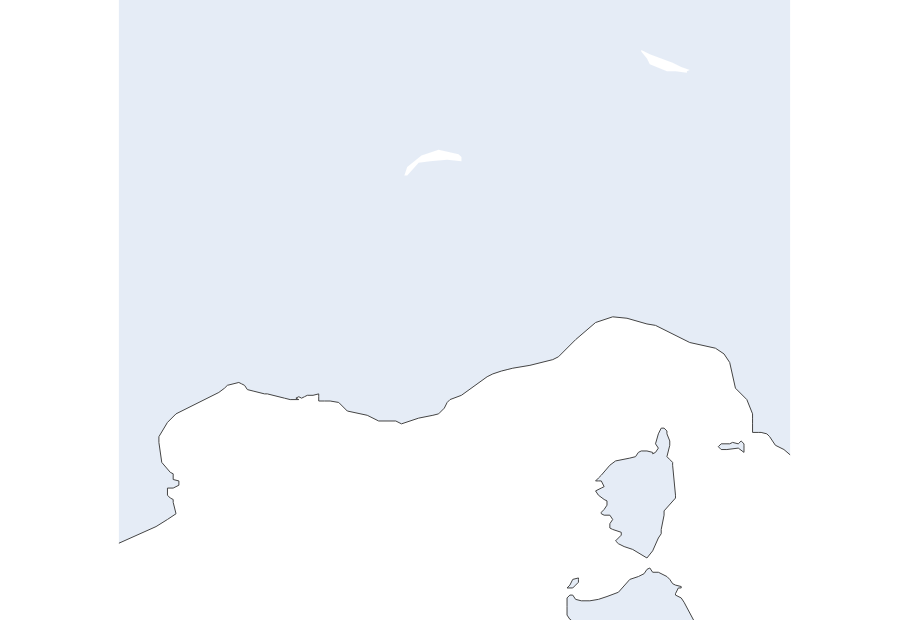

In [54]:
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd

#stations = pd.read_csv("stations_lat_lon.csv")

fig = px.scatter_geo(stations, lat = "latitude", lon = "longitude", color = "cluster", size_max = 8)#, text = "station_id")
fig.update_geos(
    resolution=50,
    showcoastlines=True,
    showland=True,
    #fitbounds = "locations",
    #visible = False,
    lonaxis_range = [-11, 2],
    lataxis_range = [49, 61],
    showframe = False,
    #scope = "europe"
)
fig.update_layout(showlegend = False, margin=dict(l=0,r=0,b=0,t=0), autosize=True, height = 620, width = 675)#, height = 675)
fig.update_traces(marker=dict(size=8))
fig.write_image("plots/locations_clusters.png", scale = 5, engine = "orca", height = 620, width = 675)
fig.show()

In [60]:
forecast_period = 48.0
for cluster in range(n_clusters):

    locations = clusters[cluster]
    x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)
    print(f"Cluster {cluster} has 80th percentile as {np.quantile(y_train, 0.8)}m/s")
    print(f"Cluster {cluster} has 90th percentile as {np.quantile(y_train, 0.9)}m/s")

Cluster 0 has 80th percentile as 4.1m/s
Cluster 0 has 90th percentile as 5.7m/s
Cluster 1 has 80th percentile as 7.7m/s
Cluster 1 has 90th percentile as 9.8m/s
Cluster 2 has 80th percentile as 5.7m/s
Cluster 2 has 90th percentile as 7.2m/s
Cluster 3 has 80th percentile as 10.3m/s
Cluster 3 has 90th percentile as 12.3m/s


## Train and evaluate

In [98]:
forecast_period = 48.0

res_norm = []
res_logistic = []

for q_tau in [0.8, 0.9]:
    for cluster in range(n_clusters):
    
        locations = clusters[cluster]
        x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)
    
        # Define threshold
        tau = np.quantile(y_train, q_tau)
        
        # Get starting values like crch
        linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
        x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
        
        #### Experiments -- Truncated Normal ####
        
        # CRPS
        res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
        res_norm.append(get_eval_df("CRPS", res_opt_crps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau))
        
        # Log likelihood
        res_opt_ll, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_ll), exp = f"Log likelihood -- {cluster}, {forecast_period}")
        res_norm.append(get_eval_df("Log likelihood", res_opt_ll, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau))
        
        # twCRPS
        res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")
        res_norm.append(get_eval_df("twCRPS", res_opt_twcrps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau))

        #### Experiments -- Truncated Logistic ####
        
        # CRPS
        res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_logistic_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
        res_logistic.append(get_eval_df("CRPS", res_opt_crps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, distribution_type = "logistic"))
        
        # Log likelihood
        res_opt_ll, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_logistic_ll), exp = f"Log likelihood -- {cluster}, {forecast_period}")
        res_logistic.append(get_eval_df("Log likelihood", res_opt_ll, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, distribution_type = "logistic"))
        
        # twCRPS
        res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = res_opt_crps.x, args = (x_train, y_train, tr_logistic_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")
        res_logistic.append(get_eval_df("twCRPS", res_opt_twcrps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, distribution_type = "logistic"))


res_norm = pd.concat(res_norm)
res_logistic = pd.concat(res_logistic)

C:\Users\jw1301\AppData\Local\Temp\ipykernel_23424\4072612730.py:6: RuntimeWarning: divide by zero encountered in divide
  return sigma*(np.log((1-p0)/(1-py)) - np.square(p0)/np.square(1-p0) * np.log(p0) - (1+p0)/(1-p0) * np.log(py) - 1/(1-p0))
C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\jw1301\AppData\Local\Temp\ipykernel_23424\4072612730.py:6: RuntimeWarning: divide by zero encountered in divide
  return sigma*(np.log((1-p0)/(1-py)) - np.square(p0)/np.square(1-p0) * np.log(p0) - (1+p0)/(1-p0) * np.log(py) - 1/(1-p0))
C:\Users\jw1301\AppData\Local\Temp\ipykernel_23424\4072612730.py:6: RuntimeWarning: divide by zero encountered in divide
  return sigma*(np.log((1-p0)/(1-py)) - np.square(p0)/np.square(1-p0) * np.log(p0) - (1+p0)/(1-p0) * np.log(py) - 1/(1-p0))
C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarni

In [122]:
res_norm.to_csv("results/res_tr_norm_all_quantiles.csv")
res_logistic.to_csv("results/res_tr_logistic_all_quantiles.csv")

In [982]:
res_norm = pd.read_csv("results/res_tr_norm_all_quantiles.csv")
res_logistic = pd.read_csv("results/res_tr_logistic_all_quantiles.csv")

In [984]:
res_skill_norm = res_norm.merge((res_norm[res_norm["Model type"] == "CRPS"]).rename(columns={"CRPS":"CRPS baseline", "twCRPS":"twCRPS baseline"})[["location", "forecast_period", "quantile", "CRPS baseline", "twCRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_skill_norm = res_skill_norm[res_skill_norm["Model type"] != "CRPS"]

res_skill_norm["Skill - CRPS (%)"] = 100*(1 - res_skill_norm["CRPS"]/res_skill_norm["CRPS baseline"])
res_skill_norm["Skill - twCRPS (%)"] = 100*(1 - res_skill_norm["twCRPS"]/res_skill_norm["twCRPS baseline"])

res_skill_logistic = res_logistic.merge((res_logistic[res_logistic["Model type"] == "CRPS"]).rename(columns={"CRPS":"CRPS baseline", "twCRPS":"twCRPS baseline"})[["location", "forecast_period", "quantile", "CRPS baseline", "twCRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_skill_logistic = res_skill_logistic[res_skill_logistic["Model type"] != "CRPS"]

res_skill_logistic["Skill - CRPS (%)"] = 100*(1 - res_skill_logistic["CRPS"]/res_skill_logistic["CRPS baseline"])
res_skill_logistic["Skill - twCRPS (%)"] = 100*(1 - res_skill_logistic["twCRPS"]/res_skill_logistic["twCRPS baseline"])


In [986]:
res_skill_norm[(res_skill_norm["Model type"] == "twCRPS") & (res_skill_norm["quantile"] == 0.9)]

Unnamed: 0.1  Unnamed: 0 Model type  location  forecast_period      CRPS  \
14            14           0     twCRPS         0             48.0  0.758551   
17            17           0     twCRPS         1             48.0  1.148969   
20            20           0     twCRPS         2             48.0  0.857763   
23            23           0     twCRPS         3             48.0  1.410170   

      twCRPS optim  x0  quantile  CRPS baseline  twCRPS baseline  \
14  0.099974  BFGS  x0       0.9       0.718703         0.102593   
17  0.140349  BFGS  x0       0.9       1.104477         0.142286   
20  0.124897  BFGS  x0       0.9       0.825895         0.126567   
23  0.170835  BFGS  x0       0.9       1.394275         0.170913   

    Skill - CRPS (%)  Skill - twCRPS (%)  
14         -5.544422            2.552577  
17         -4.028336            1.361500  
20         -3.858657            1.319545  
23         -1.139956            0.045867

In [988]:
res_skill_logistic[(res_skill_logistic["Model type"] == "twCRPS") & (res_skill_logistic["quantile"] == 0.9)]

Unnamed: 0.1  Unnamed: 0 Model type  location  forecast_period      CRPS  \
14            14           0     twCRPS         0             48.0  0.750605   
17            17           0     twCRPS         1             48.0  1.133330   
20            20           0     twCRPS         2             48.0  0.852267   
23            23           0     twCRPS         3             48.0  1.404402   

      twCRPS optim  x0  quantile  CRPS baseline  twCRPS baseline  \
14  0.100238  BFGS  x0       0.9       0.717763         0.102263   
17  0.140382  BFGS  x0       0.9       1.103483         0.141665   
20  0.125178  BFGS  x0       0.9       0.825275         0.126432   
23  0.170572  BFGS  x0       0.9       1.392351         0.170884   

    Skill - CRPS (%)  Skill - twCRPS (%)  
14         -4.575617            1.979948  
17         -2.704732            0.905720  
20         -3.270673            0.991785  
23         -0.865522            0.182330

In [824]:
res_skill_norm[(res_skill_norm["Model type"] == "twCRPS") & (res_skill_norm["quantile"] == 0.8)]

Unnamed: 0.1  Unnamed: 0 Model type  location  forecast_period      CRPS  \
2              2           0     twCRPS         0             48.0  0.733546   
5              5           0     twCRPS         1             48.0  1.130312   
8              8           0     twCRPS         2             48.0  0.841107   
11            11           0     twCRPS         3             48.0  1.400318   

      twCRPS optim  x0  quantile  CRPS baseline  twCRPS baseline  \
2   0.218538  BFGS  x0       0.8       0.718703         0.221544   
5   0.287334  BFGS  x0       0.8       1.104477         0.290971   
8   0.221091  BFGS  x0       0.8       0.825895         0.222556   
11  0.308897  BFGS  x0       0.8       1.394275         0.308972   

    Skill - CRPS (%)  Skill - twCRPS (%)  
2          -2.065249            1.356682  
5          -2.339075            1.250166  
8          -1.841916            0.658155  
11         -0.433356            0.024259

In [828]:
def full_range(x):
    return (np.min(x), np.max(x))

Smallest improvement for cluster with largest wind speed, but decent one for second largest.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\345318535.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\345318535.py:63: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



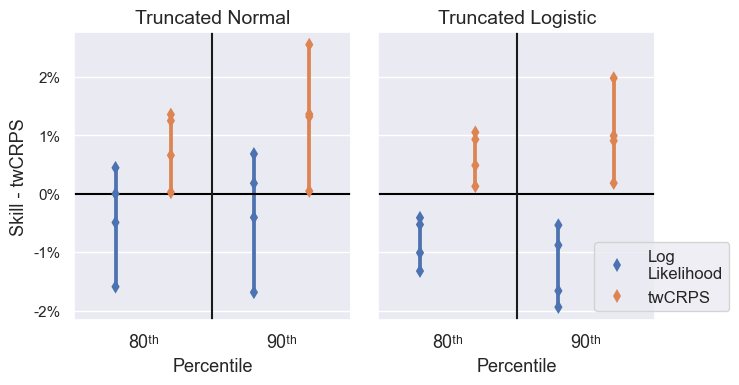

In [1064]:
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7.5, 3.75), sharey = True, sharex = False)
sns.stripplot(
    y = "Skill - twCRPS (%)",
    x = "quantile",
    hue = "Model type",
    dodge = True,
    data = res_skill_norm[res_skill_norm["Model type"].isin(["Log likelihood", "twCRPS"])],#["quantile"] == 0.8],
    ax = axs[0],
    size = 7,
    jitter = False,
    marker = "d"
)
sns.pointplot(
    y = "Skill - twCRPS (%)",
    x = "quantile",
    hue = "Model type",
    data = res_skill_norm[res_skill_norm["Model type"].isin(["Log likelihood", "twCRPS"])],#["quantile"] == 0.8],
    ax = axs[0],
    markers = "none",
    dodge = .4,
    errorbar = full_range,
    linestyles = "none"
)
axs[0].axhline(0, color = "black")
axs[0].set_xlabel("Percentile", fontsize = 13)
axs[0].set_ylabel("Skill - twCRPS", fontsize = 13)
axs[0].set_title("Truncated Normal", fontsize = 14)
axs[0].axvline(axs[0].get_xticks()[0] + 0.5, color="k")
axs[0].get_legend().remove()
axs[0].set_xticklabels(["80ᵗʰ", "90ᵗʰ"], fontsize = 13)


sns.stripplot(
    y = "Skill - twCRPS (%)",
    x = "quantile",
    hue = "Model type",
    dodge = True,
    data = res_skill_logistic[res_skill_logistic["Model type"].isin(["Log likelihood", "twCRPS"])],#["quantile"] == 0.8],
    ax = axs[1],
    size = 7,
    jitter = False,
    marker = "d"
)
sns.pointplot(
    y = "Skill - twCRPS (%)",
    x = "quantile",
    hue = "Model type",
    data = res_skill_logistic[res_skill_logistic["Model type"].isin(["Log likelihood", "twCRPS"])],#["quantile"] == 0.8],
    ax = axs[1],
    markers = "none",
    dodge = .4,
    errorbar = full_range,
    linestyles = "none"
)
axs[1].axhline(0, color = "black")
axs[1].set_ylabel("")
axs[1].set_xlabel("Percentile", fontsize = 13)
axs[1].set_title("Truncated Logistic", fontsize = 14)
axs[1].axvline(axs[1].get_xticks()[0] + 0.5, color="k")
axs[1].get_legend().remove()
axs[1].set_xticklabels(["80ᵗʰ", "90ᵗʰ"], fontsize = 13)


handles, labels = axs[1].get_legend_handles_labels()
#fig.legend(handles, labels, bbox_to_anchor=(0.6,0.28))
fig.legend(handles, ["Log\nLikelihood", "twCRPS"], bbox_to_anchor=(1.01,0.34), prop={'size': 12})

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
#plt.ylim(-15)
plt.subplots_adjust(wspace=0.1)

plt.savefig("plots/twcrps_small.png", dpi=300, bbox_inches = "tight")


C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\241135631.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\241135631.py:63: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



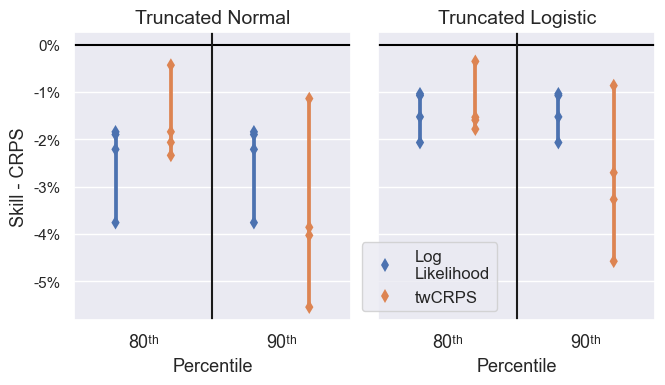

In [1066]:
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7.5, 3.75), sharey = True, sharex = False)
sns.stripplot(
    y = "Skill - CRPS (%)",
    x = "quantile",
    hue = "Model type",
    dodge = True,
    data = res_skill_norm[res_skill_norm["Model type"].isin(["Log likelihood", "twCRPS"])],#["quantile"] == 0.8],
    ax = axs[0],
    size = 7,
    jitter = False,
    marker = "d"
)
sns.pointplot(
    y = "Skill - CRPS (%)",
    x = "quantile",
    hue = "Model type",
    data = res_skill_norm[res_skill_norm["Model type"].isin(["Log likelihood", "twCRPS"])],#["quantile"] == 0.8],
    ax = axs[0],
    markers = "none",
    dodge = .4,
    errorbar = full_range,
    linestyles = "none"
)
axs[0].axhline(0, color = "black")
axs[0].set_xlabel("Percentile", fontsize = 13)
axs[0].set_ylabel("Skill - CRPS", fontsize = 13)
axs[0].set_title("Truncated Normal", fontsize = 14)
axs[0].axvline(axs[0].get_xticks()[0] + 0.5, color="k")
axs[0].get_legend().remove()
axs[0].set_xticklabels(["80ᵗʰ", "90ᵗʰ"], fontsize = 13)


sns.stripplot(
    y = "Skill - CRPS (%)",
    x = "quantile",
    hue = "Model type",
    dodge = True,
    data = res_skill_logistic[res_skill_logistic["Model type"].isin(["Log likelihood", "twCRPS"])],#["quantile"] == 0.8],
    ax = axs[1],
    size = 7,
    jitter = False,
    marker = "d"
)
sns.pointplot(
    y = "Skill - CRPS (%)",
    x = "quantile",
    hue = "Model type",
    data = res_skill_logistic[res_skill_logistic["Model type"].isin(["Log likelihood", "twCRPS"])],#["quantile"] == 0.8],
    ax = axs[1],
    markers = "none",
    dodge = .4,
    errorbar = full_range,
    linestyles = "none"
)
axs[1].axhline(0, color = "black")
axs[1].set_ylabel("")
axs[1].set_xlabel("Percentile", fontsize = 13)
axs[1].set_title("Truncated Logistic", fontsize = 14)
axs[1].axvline(axs[1].get_xticks()[0] + 0.5, color="k")
axs[1].get_legend().remove()
axs[1].set_xticklabels(["80ᵗʰ", "90ᵗʰ"], fontsize = 13)


handles, labels = axs[1].get_legend_handles_labels()
#fig.legend(handles, labels, bbox_to_anchor=(0.6,0.28))
fig.legend(handles, ["Log\nLikelihood", "twCRPS"], bbox_to_anchor=(0.7,0.34), prop={'size': 12})

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
#plt.ylim(-15)
plt.subplots_adjust(wspace=0.1)

plt.savefig("plots/crps_small.png", dpi=300, bbox_inches = "tight")


### Trade-off

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\852588224.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\852588224.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\852588224.py:11: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



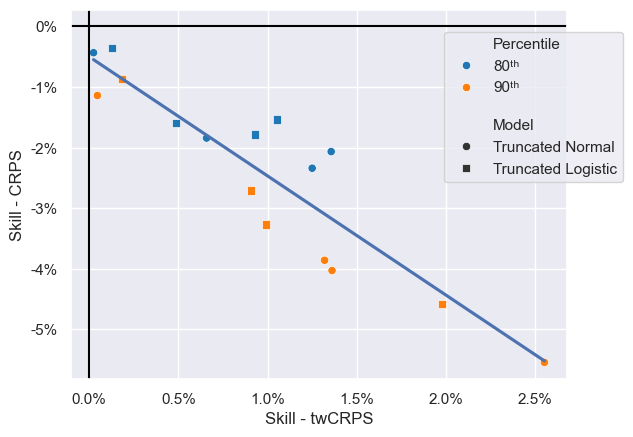

In [844]:
subset1 = res_skill_norm[(res_skill_norm["Model type"] == "twCRPS")]
subset1["Model"] = "Truncated Normal"

subset2 = res_skill_logistic[(res_skill_logistic["Model type"] == "twCRPS")]
subset2["Model"] = "Truncated Logistic"

df = pd.concat([subset1, subset2])

fig, ax = plt.subplots()

sns.scatterplot(df, y = "Skill - CRPS (%)", x = "Skill - twCRPS (%)", style = "Model", hue = "quantile", palette = sns.color_palette("tab10"), markers=['o', 's'], ax = ax)
sns.regplot(df, y = "Skill - CRPS (%)", x = "Skill - twCRPS (%)", scatter = False, ci = False, ax = ax)
ax.axhline(0, color = "black")
ax.axvline(0, color = "black")
ax.set_xlabel("Skill - twCRPS")
ax.set_ylabel("Skill - CRPS")

ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, bbox_to_anchor=(0.6,0.28))
fig.legend(handles, ["Percentile", "80ᵗʰ", "90ᵗʰ", "\nModel", "Truncated Normal", "Truncated Logistic"], bbox_to_anchor=(1.,0.85))

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%s%%'))

#plt.ylim(-15)
plt.subplots_adjust(wspace=0.1)

plt.savefig("plots/crps_vs_twcrps.png", dpi=300, bbox_inches = "tight")


## Extremal calibration

Conditional PIT histograms:

In [1146]:
def tr_norm_CDF(x, mu, sigma):
    """CDF of truncated normal distribution"""
    s = (x-mu)/sigma
    alpha = -mu/sigma
    
    return (Phi(s) - Phi(alpha))/(1-Phi(alpha))

def get_tr_norm_PIT(x, mu, sigma):
    return tr_norm_CDF(x, mu, sigma)

def get_tr_norm_cond_PIT(x, mu, sigma, t = 0):
    mu, sigma = mu[x > t], sigma[x > t]
    x = x[x > t]
    F_t = tr_norm_CDF(t, mu, sigma)
    return (tr_norm_CDF(x, mu, sigma) - F_t)/(1-F_t)


In [884]:
q_tau = 0.9

cond_pit_vals = {"CRPS": [], "Log likelihood": [], "twCRPS": []}
occ_ratio = {"CRPS": [], "Log likelihood": [], "twCRPS": []}

for cluster in range(n_clusters):

    locations = clusters[cluster]
    x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)

    # Define threshold
    tau = np.quantile(y_train, q_tau)
    
    # Get starting values like crch
    linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
    x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
    
    #### Experiments -- Truncated Normal ####
    
    # CRPS
    res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
    cond_pit_vals["CRPS"].append(get_tr_norm_cond_PIT(y_test, *model(res_opt_crps.x, x_test), t = tau))
    occ_ratio["CRPS"].append(len(y_test[y_test > tau]) / np.sum(1 - tr_norm_CDF(tau, *model(res_opt_crps.x, x_test))))
    
    # Log likelihood
    res_opt_ll, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_ll), exp = f"Log likelihood -- {cluster}, {forecast_period}")
    cond_pit_vals["Log likelihood"].append(get_tr_norm_cond_PIT(y_test, *model(res_opt_ll.x, x_test), t = tau))
    occ_ratio["Log likelihood"].append(len(y_test[y_test > tau]) / np.sum(1 - tr_norm_CDF(tau, *model(res_opt_ll.x, x_test))))

    # twCRPS
    res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")
    cond_pit_vals["twCRPS"].append(get_tr_norm_cond_PIT(y_test, *model(res_opt_twcrps.x, x_test), t = tau))
    occ_ratio["twCRPS"].append(len(y_test[y_test > tau]) / np.sum(1 - tr_norm_CDF(tau, *model(res_opt_twcrps.x, x_test))))



array([<Axes: >, <Axes: >], dtype=object)

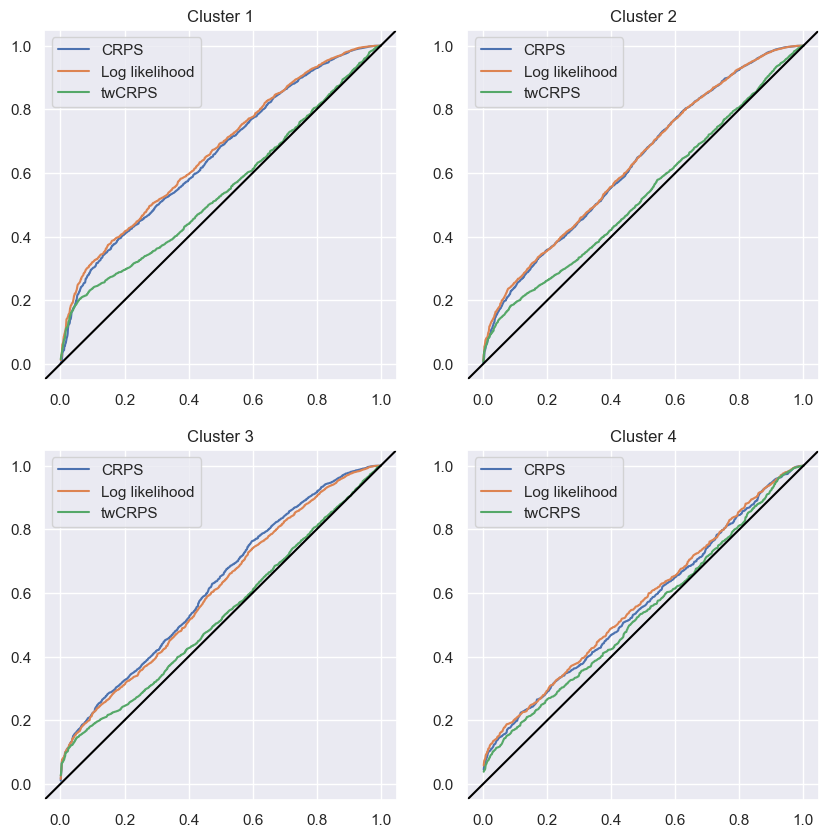

In [894]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

cluster_paper_to_cluster_here = [0, 2, 1, 3]
for i, ax in enumerate(axs.ravel()):
    cluster = cluster_paper_to_cluster_here[i]
    x_vals = np.arange(1, len(cond_pit_vals["CRPS"][cluster])+1, 1)/len(cond_pit_vals["CRPS"][cluster])
    ax.plot(x_vals, np.sort(cond_pit_vals["CRPS"][cluster]), label = "CRPS")
    ax.plot(x_vals, np.sort(cond_pit_vals["Log likelihood"][cluster]), label = "Log likelihood")
    ax.plot(x_vals, np.sort(cond_pit_vals["twCRPS"][cluster]), label = "twCRPS")
    ax.axline((0,0), slope = 1, color = "black")
    ax.set_title(f"Cluster {i+1}")
    ax.legend()
plt.savefig("plots/cond_pit_square.png", dpi=300, bbox_inches = "tight")


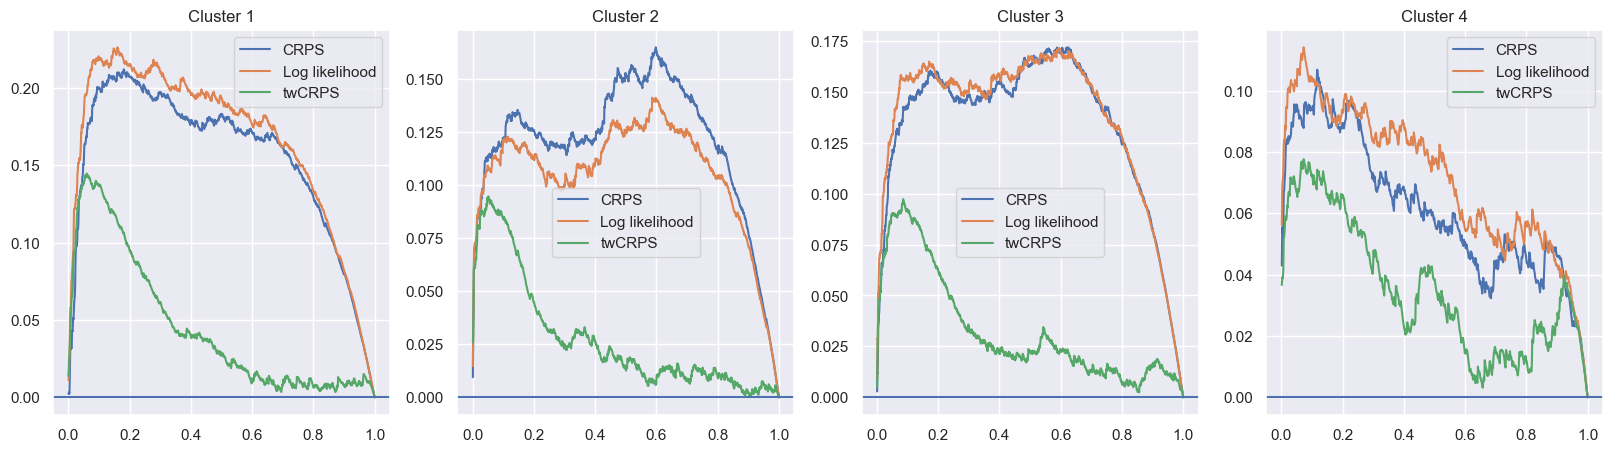

In [166]:
fig, axs = plt.subplots(1, n_clusters, figsize = (5*n_clusters, 5))

for i in range(n_clusters):

    x_vals = np.arange(1, len(cond_pit_vals["CRPS"][i])+1, 1)/len(cond_pit_vals["CRPS"][i])
    axs[i].plot(x_vals, np.abs(x_vals - np.sort(cond_pit_vals["CRPS"][i])), label = "CRPS")
    axs[i].plot(x_vals, np.abs(x_vals - np.sort(cond_pit_vals["Log likelihood"][i])), label = "Log likelihood")
    axs[i].plot(x_vals, np.abs(x_vals - np.sort(cond_pit_vals["twCRPS"][i])), label = "twCRPS")
    axs[i].axline((0,0), slope = 0)
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].legend()
plt.savefig("plots/cond_pit_shifted.png", dpi=300, bbox_inches = "tight")


As a function of threshold:

In [145]:

TMCB_norm = []

for q_tau in [0.8, 0.9]:
    for cluster in range(n_clusters):
    
        locations = clusters[cluster]
        x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)
    
        # Define threshold
        tau = np.quantile(y_train, q_tau)
        
        # Get starting values like crch
        linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
        x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
        
        #### Experiments -- Truncated Normal ####
        
        # CRPS
        res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
        
        # Log likelihood
        res_opt_ll, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_ll), exp = f"Log likelihood -- {cluster}, {forecast_period}")
    
        # twCRPS
        res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")
    
        for eval_q_tau in np.linspace(q_tau, 0.999, 20):
            tau_eval = np.quantile(y_train, eval_q_tau)
            
            cond_pit_vals = get_tr_norm_cond_PIT(y_test, *model(res_opt_crps.x, x_test), t = tau_eval)
            occ_ratio = len(y_test[y_test > tau_eval]) / np.sum(1 - tr_norm_CDF(tau_eval, *model(res_opt_crps.x, x_test)))
            x_vals = np.arange(1, len(cond_pit_vals)+1, 1)/len(cond_pit_vals)
            TMCB_norm.append(pd.DataFrame({"Model": "CRPS", "Training quantile": q_tau, "TMCB": np.max(np.abs(np.sort(cond_pit_vals) * occ_ratio - x_vals)), "eval_quantile": eval_q_tau, "location": cluster}, index = [0]))
    
            cond_pit_vals = get_tr_norm_cond_PIT(y_test, *model(res_opt_ll.x, x_test), t = tau_eval)
            occ_ratio = len(y_test[y_test > tau_eval]) / np.sum(1 - tr_norm_CDF(tau_eval, *model(res_opt_ll.x, x_test)))
            x_vals = np.arange(1, len(cond_pit_vals)+1, 1)/len(cond_pit_vals)
            TMCB_norm.append(pd.DataFrame({"Model": "Log likelihood", "Training quantile": q_tau, "TMCB": np.max(np.abs(np.sort(cond_pit_vals) * occ_ratio - x_vals)), "eval_quantile": eval_q_tau, "location": cluster}, index = [0]))
    
            cond_pit_vals = get_tr_norm_cond_PIT(y_test, *model(res_opt_twcrps.x, x_test), t = tau_eval)
            occ_ratio = len(y_test[y_test > tau_eval]) / np.sum(1 - tr_norm_CDF(tau_eval, *model(res_opt_twcrps.x, x_test)))
            x_vals = np.arange(1, len(cond_pit_vals)+1, 1)/len(cond_pit_vals)
            TMCB_norm.append(pd.DataFrame({"Model": "twCRPS", "Training quantile": q_tau, "TMCB": np.max(np.abs(np.sort(cond_pit_vals) * occ_ratio - x_vals)), "eval_quantile": eval_q_tau, "location": cluster}, index = [0]))

TMCB_norm = pd.concat(TMCB_norm)

In [146]:
TMCB_norm.to_csv("results/tmcb_norm.csv")

In [170]:
TMCB_norm = pd.read_csv("results/tmcb_norm.csv")

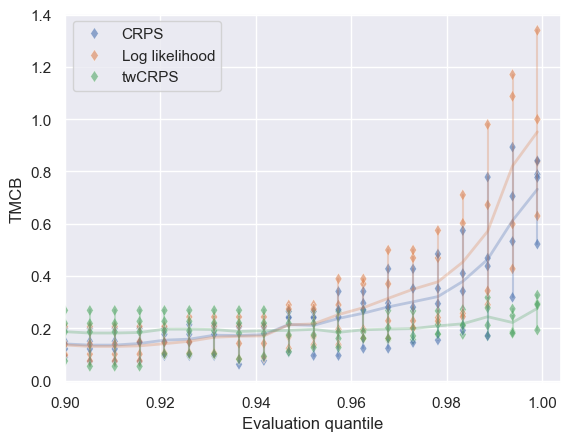

In [172]:
sns.lineplot(
    x = "eval_quantile",
    y = "TMCB",
    hue = "Model",
    data = TMCB_norm[TMCB_norm["Training quantile"] == 0.9],
    #marker = "d",
    legend = False,
    linewidth = 2,
    alpha = 0.3,
    errorbar = full_range,
    err_style="bars",
)
sns.scatterplot(
    x = "eval_quantile",
    y = "TMCB",
    hue = "Model",
    data = TMCB_norm[TMCB_norm["Training quantile"] == 0.9],
    marker = "d",
    #legend = False,
    alpha = 0.6,
    #linewidth = 2,
    
)
plt.xlim(0.9)
plt.xlabel('Evaluation quantile')
plt.ylabel("TMCB")
plt.legend()
plt.savefig("plots/TMCB_function_of_threshold_vis_1.png", dpi=300, bbox_inches = "tight")


## Varying threshold

In [1184]:
def sample_brier_score(mu, sigma, y, n_samples, tau):
    pred = sample_tr_norm(mu, sigma, n_samples)
    o_t = (y > tau)*1
    f_t = np.mean(pred > tau, axis = -1)
    return np.mean(np.square(f_t - o_t))

def sample_RMSE(mu, sigma, y, n_samples, tau):
    pred = sample_tr_norm(mu, sigma, n_samples)
    w = (y > tau)*1
    return np.mean(w*np.square(y - np.mean(pred, axis = -1)))

def sample_tr_norm(mu, sigma, n_samples):
    mu, sigma = np.repeat(np.expand_dims(np.array(mu), -1), n_samples, -1), np.repeat(np.expand_dims(np.array(sigma), -1), n_samples, -1)
    
    q_0 = scipy.stats.norm.cdf(0, loc = mu, scale = sigma)
    quantiles = q_0 + np.random.rand(*mu.shape)*(1-q_0)
    
    return scipy.stats.norm.ppf(quantiles, loc = mu, scale = sigma)

def sample_brier_score_tr_logistic(mu, sigma, y, n_samples, tau):
    pred = sample_tr_logistic(mu, sigma, n_samples)
    o_t = (y > tau)*1
    f_t = np.mean(pred > tau, axis = -1)
    return np.mean(np.square(f_t - o_t))

def logistic_quantile(p, loc, scale):
    return loc + scale * np.log(p/(1-p))

def logistic_cdf(x, loc, scale):
    return 1/(1+ np.exp(-(x-loc)/scale))

def sample_tr_logistic(mu, sigma, n_samples):
    mu, sigma = np.repeat(np.expand_dims(np.array(mu), -1), n_samples, -1), np.repeat(np.expand_dims(np.array(sigma), -1), n_samples, -1)
    
    q_0 = logistic_cdf(0, loc = mu, scale = sigma)
    quantiles = q_0 + np.random.rand(*mu.shape)*(1-q_0)
    
    return logistic_quantile(quantiles, loc = mu, scale = sigma)

def tr_logistic_CDF(x, mu, sigma):
    """CDF of truncated logistic distribution"""
    return (L_CDF(x, mu, sigma) - L_CDF(0, mu, sigma))/(1-L_CDF(0, mu, sigma))

def brier_score_tr_norm(mu, sigma, y, tau):
    f_t = 1 - tr_norm_CDF(tau, mu, sigma)
    o_t = (y > tau)*1
    return np.mean(np.square(f_t - o_t))

def brier_score_tr_logistic(mu, sigma, y, tau):
    f_t = 1 - tr_logistic_CDF(tau, mu, sigma)
    o_t = (y > tau)*1
    return np.mean(np.square(f_t - o_t))


In [1186]:
forecast_period = 48.0

res = []
brier_scores = []
TMCB_norm = []

for q_tau in [0.6, 0.8, 0.9, 0.95]:
    for cluster in range(n_clusters):
    
        locations = clusters[cluster]
        x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)
    
        # Define threshold
        tau = np.quantile(y_train, q_tau)
        
        # Get starting values like crch
        linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
        x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
        
        #### Experiments -- Truncated Normal ####
        
        # CRPS
        res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
                
        # twCRPS
        res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")


        for eval_q_tau in [*list(np.arange(0, 1.0, 0.0125)), 0.99]:
        
            eval_tau = np.quantile(y_train, eval_q_tau)
            
            res.append(get_eval_df("CRPS", res_opt_crps, x_test, y_test, eval_tau, optim_meta, cluster, forecast_period, q_tau, eval_q_tau = eval_q_tau))
            res.append(get_eval_df("twCRPS", res_opt_twcrps, x_test, y_test, eval_tau, optim_meta, cluster, forecast_period, q_tau, eval_q_tau = eval_q_tau))
            
            brier_score = get_model_score_eval(res_opt_crps.x, x_test, y_test, score = brier_score_tr_norm, tau = eval_tau)
            brier_scores.append(pd.DataFrame({"training_q_tau": q_tau, "eval_q_tau": eval_q_tau, "Model type": "CRPS", "Brier Score": brier_score, "location": cluster}, index = [0]))
            
            brier_score = get_model_score_eval(res_opt_twcrps.x, x_test, y_test, score = brier_score_tr_norm, tau = eval_tau)
            brier_scores.append(pd.DataFrame({"training_q_tau": q_tau, "eval_q_tau": eval_q_tau, "Model type": "twCRPS", "Brier Score": brier_score, "location": cluster}, index = [0]))

            cond_pit_vals = get_tr_norm_cond_PIT(y_test, *model(res_opt_crps.x, x_test), t = eval_tau)
            occ_ratio = len(y_test[y_test > eval_tau]) / np.sum(1 - tr_norm_CDF(eval_tau, *model(res_opt_crps.x, x_test)))
            x_vals = np.arange(1, len(cond_pit_vals)+1, 1)/len(cond_pit_vals)
            TMCB_norm.append(pd.DataFrame({"Model": "CRPS", "Training quantile": q_tau, "TMCB": np.max(np.abs(np.sort(cond_pit_vals) * occ_ratio - x_vals)), "eval_quantile": eval_q_tau, "location": cluster}, index = [0]))
        
            cond_pit_vals = get_tr_norm_cond_PIT(y_test, *model(res_opt_twcrps.x, x_test), t = eval_tau)
            occ_ratio = len(y_test[y_test > eval_tau]) / np.sum(1 - tr_norm_CDF(eval_tau, *model(res_opt_twcrps.x, x_test)))
            x_vals = np.arange(1, len(cond_pit_vals)+1, 1)/len(cond_pit_vals)
            TMCB_norm.append(pd.DataFrame({"Model": "twCRPS", "Training quantile": q_tau, "TMCB": np.max(np.abs(np.sort(cond_pit_vals) * occ_ratio - x_vals)), "eval_quantile": eval_q_tau, "location": cluster}, index = [0]))




res = pd.concat(res)
brier_scores = pd.concat(brier_scores)
TMCB_norm = pd.concat(TMCB_norm)

In [1187]:
res.to_csv("results/varying_threshold_tr_norm.csv")
brier_scores.to_csv("results/varying_threshold_tr_norm_brier_score.csv")
TMCB_norm.to_csv("results/varying_threshold_TMCB_norm.csv")

In [1204]:
res = pd.read_csv("results/varying_threshold_tr_norm.csv")
brier_scores = pd.read_csv("results/varying_threshold_tr_norm_brier_score.csv")
TMCB_norm = pd.read_csv("results/varying_threshold_TMCB_norm.csv")

In [1206]:
res_skill = res.merge((res[res["Model type"] == "CRPS"]).rename(columns={"CRPS":"CRPS baseline", "twCRPS":"twCRPS baseline"})[["location", "forecast_period", "quantile", "CRPS baseline", "twCRPS baseline", "eval_q_tau"]], on = ["location", "forecast_period", "quantile", "eval_q_tau"])
res_skill = res_skill[res_skill["Model type"] != "CRPS"]

res_skill["Skill - CRPS (%)"] = 100*(1 - res_skill["CRPS"]/res_skill["CRPS baseline"])
res_skill["Skill - twCRPS (%)"] = 100*(1 - res_skill["twCRPS"]/res_skill["twCRPS baseline"])

res_skill["Evaluation quantile"] = res_skill["eval_q_tau"]
res_skill["Training quantile"] = res_skill["quantile"]


C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\3029538542.py:1: UserWarning:

The palette list has more values (8) than needed (4), which may not be intended.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\3029538542.py:15: UserWarning:

The palette list has more values (8) than needed (4), which may not be intended.



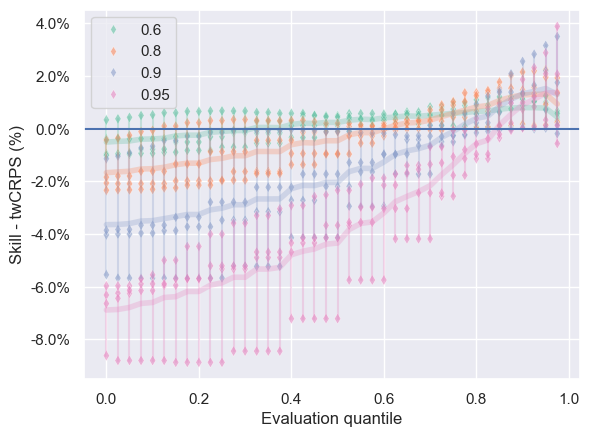

In [1224]:
sns.lineplot(
    x = "Evaluation quantile",
    y = "Skill - twCRPS (%)",
    hue = "Training quantile",
    data = res_skill[np.isclose(res_skill["Evaluation quantile"].values[:, None], np.arange(0, 1.0, 0.025))],
    #marker = "d",
    legend = False,
    linewidth = 4,
    alpha = 0.3,
    errorbar = full_range,
    err_style="bars",
    palette = sns.color_palette("Set2"),

)
sns.scatterplot(
    x = "Evaluation quantile",
    y = "Skill - twCRPS (%)",
    hue = "Training quantile",
    data = res_skill[np.isclose(res_skill["Evaluation quantile"].values[:, None], np.arange(0, 1.0, 0.025))],
    marker = "d",
    #legend = False,
    alpha = 0.6,
    #linewidth = 2,
    s = 30,
    palette = sns.color_palette("Set2"),
    
)
ax.set_xlabel('Evaluation quantile')
ax.set_ylabel("TMCB")
plt.legend()
plt.axhline(0)
#plt.xlim(0)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%s%%'))
plt.savefig("plots/twcrps_varying_threshold.png", dpi=300, bbox_inches = "tight")


C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\2997813354.py:16: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\2997813354.py:16: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\2997813354.py:16: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\2997813354.py:16: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.



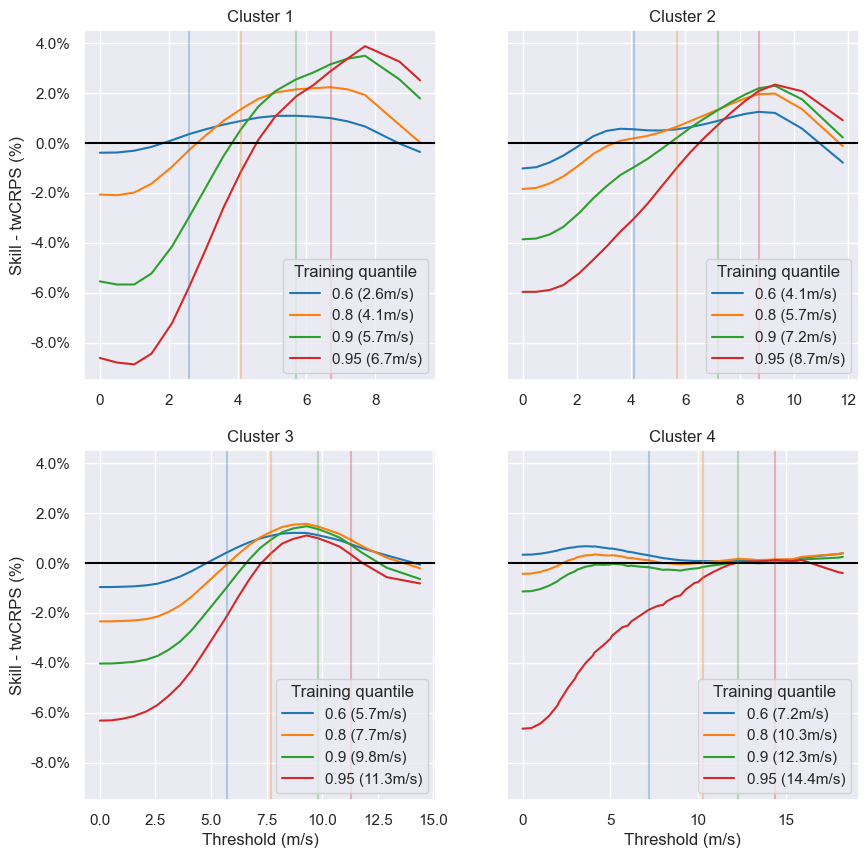

In [1191]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10), sharex = False, sharey = True)

cluster_paper_to_cluster_here = [0, 2, 1, 3]

for i, ax in enumerate(axs.ravel()):
    cluster = cluster_paper_to_cluster_here[i]
    locations = clusters[cluster]
    x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)
    
    q_vals = np.arange(0, 1.0, 0.025)  
    eval_tau = np.quantile(y_train, q_vals)
    
    df = res_skill[(res_skill["location"] == cluster)].copy()
    df["Threshold (m/s)"] = np.quantile(y_train, df["Evaluation quantile"])
        
    sns.lineplot(
        x = "Threshold (m/s)", 
        y = "Skill - twCRPS (%)",
        hue = "Training quantile",
        errorbar = None,
        data = df,
        ax = ax,
        palette = sns.color_palette("tab10")
    )
    ax.axhline(0, color = "black")
    ax.set_title("Cluster %s"%(i+1))
    if i == 1 or i == 3:
        ax.set_ylabel("")
    if i == 0 or i == 1:
        ax.set_xlabel("")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%s%%'))
    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [f"{q} ({np.round(np.quantile(y_train, q), 2)}m/s)" for q in [0.6, 0.8, 0.9, 0.95]], loc = "lower right", title = "Training quantile")
    for i, q in enumerate([0.6, 0.8, 0.9, 0.95]):
        ax.axvline(np.quantile(y_train, q), color = sns.color_palette("tab10")[i], alpha = 0.3)

    

plt.savefig("plots/twcrps_varying_threshold_absolute.png", dpi=300, bbox_inches = "tight")


In [1192]:
#brier_scores = pd.concat(brier_scores, ignore_index = True)

brier_scores_skill = brier_scores.merge(brier_scores[brier_scores["Model type"] == "CRPS"][["training_q_tau", "eval_q_tau", "location", "Brier Score"]], on = ["training_q_tau", "eval_q_tau", "location"], suffixes = ["", "_CRPS"])
brier_scores_skill = brier_scores_skill[brier_scores_skill["Model type"] != "CRPS"]

brier_scores_skill["Skill - Brier score (%)"] = 100*(1-brier_scores_skill["Brier Score"]/brier_scores_skill["Brier Score_CRPS"])

brier_scores_skill["Evaluation quantile"] = brier_scores_skill["eval_q_tau"]
brier_scores_skill["Training quantile"] = brier_scores_skill["training_q_tau"]



C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\3607985783.py:16: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\3607985783.py:16: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\3607985783.py:16: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\3607985783.py:16: UserWarning:

The palette list has more values (10) than needed (4), which may not be intended.



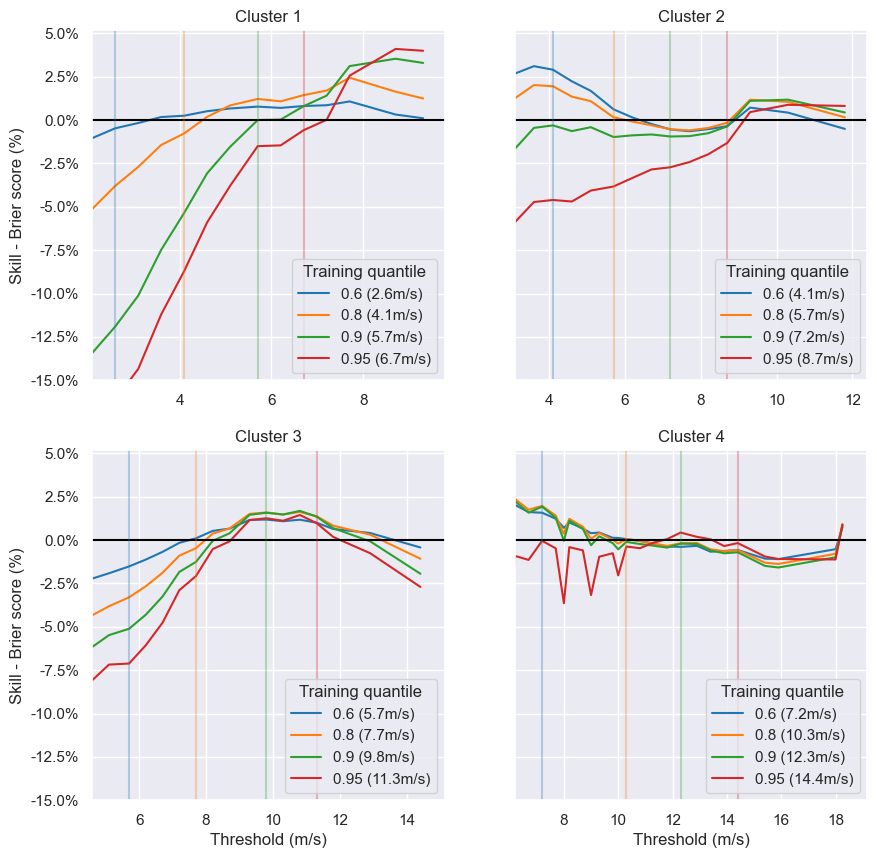

In [1193]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10), sharex = False, sharey = True)

cluster_paper_to_cluster_here = [0, 2, 1, 3]

for i, ax in enumerate(axs.ravel()):
    cluster = cluster_paper_to_cluster_here[i]
    locations = clusters[cluster]
    x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)
    
    q_vals = np.arange(0, 1.0, 0.025)  
    eval_tau = np.quantile(y_train, q_vals)
    
    df = brier_scores_skill[(brier_scores_skill["location"] == cluster)].copy()
    df["Threshold (m/s)"] = np.quantile(y_train, df["Evaluation quantile"])
        
    sns.lineplot(
        x = "Threshold (m/s)", 
        y = "Skill - Brier score (%)",
        hue = "Training quantile",
        errorbar = None,
        data = df,
        ax = ax,
        palette = sns.color_palette("tab10")
    )
    ax.axhline(0, color = "black")
    ax.set_title("Cluster %s"%(i+1))
    if i == 1 or i == 3:
        ax.set_ylabel("")
    if i == 0 or i == 1:
        ax.set_xlabel("")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%s%%'))
    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [f"{q} ({np.round(np.quantile(y_train, q), 2)}m/s)" for q in [0.6, 0.8, 0.9, 0.95]], loc = "lower right", title = "Training quantile")
    for i, q in enumerate([0.6, 0.8, 0.9, 0.95]):
        ax.axvline(np.quantile(y_train, q), color = sns.color_palette("tab10")[i], alpha = 0.3)
    ax.set_xlim(np.quantile(y_train, 0.5))
    ax.set_ylim(-15)

    

plt.savefig("plots/bs_varying_threshold_absolute.png", dpi=300, bbox_inches = "tight")


### Brier score table

In [1168]:
forecast_period = 48.0

brier_scores_norm = []
brier_scores_logistic = []

for q_tau in [0.6, 0.8, 0.9, 0.95]:
    for cluster in range(n_clusters):
    
        locations = clusters[cluster]
        x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)
    
        # Define threshold
        tau = np.quantile(y_train, q_tau)
        
        # Get starting values like crch
        linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
        x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
        
        #### Experiments -- Truncated Normal ####
        
        # CRPS
        res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
                
        # twCRPS
        res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")

        for eval_q_tau in [0.7, 0.8, 0.85, 0.9, 0.95]:
        
            eval_tau = np.quantile(y_train, eval_q_tau)
                        
            brier_score = get_model_score_eval(res_opt_crps.x, x_test, y_test, score = brier_score_tr_norm, tau = eval_tau)
            brier_scores_norm.append(pd.DataFrame({"training_q_tau": q_tau, "eval_q_tau": eval_q_tau, "Model type": "CRPS", "Brier Score": brier_score, "location": cluster}, index = [0]))
            
            brier_score = get_model_score_eval(res_opt_twcrps.x, x_test, y_test, score = brier_score_tr_norm, tau = eval_tau)
            brier_scores_norm.append(pd.DataFrame({"training_q_tau": q_tau, "eval_q_tau": eval_q_tau, "Model type": "twCRPS", "Brier Score": brier_score, "location": cluster}, index = [0]))


        #### Experiments -- Truncated Logistic ####
        
        # CRPS
        res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_logistic_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
                
        # twCRPS
        res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = res_opt_crps.x, args = (x_train, y_train, tr_logistic_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")


        for eval_q_tau in [0.7, 0.8, 0.85, 0.9, 0.95]:
        
            eval_tau = np.quantile(y_train, eval_q_tau)
                        
            brier_score = get_model_score_eval(res_opt_crps.x, x_test, y_test, score = brier_score_tr_logistic, tau = eval_tau)
            brier_scores_logistic.append(pd.DataFrame({"training_q_tau": q_tau, "eval_q_tau": eval_q_tau, "Model type": "CRPS", "Brier Score": brier_score, "location": cluster}, index = [0]))
            
            brier_score = get_model_score_eval(res_opt_twcrps.x, x_test, y_test, score = brier_score_tr_logistic, tau = eval_tau)
            brier_scores_logistic.append(pd.DataFrame({"training_q_tau": q_tau, "eval_q_tau": eval_q_tau, "Model type": "twCRPS", "Brier Score": brier_score, "location": cluster}, index = [0]))




brier_scores_norm = pd.concat(brier_scores_norm)
brier_scores_logistic = pd.concat(brier_scores_logistic)


C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:6: RuntimeWarning:

divide by zero encountered in divide

C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning:

invalid value encountered in subtract

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:6: RuntimeWarning:

divide by zero encountered in divide

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:6: RuntimeWarning:

divide by zero encountered in divide

C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning:

invalid value encountered in subtract

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:6: RuntimeWarning:

divide by zero encountered in divide

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:6: RuntimeWarning:

divide by zero encountered in divide

C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: Run

In [1180]:
brier_scores_skill = brier_scores_logistic.merge(brier_scores_logistic[brier_scores_logistic["Model type"] == "CRPS"][["training_q_tau", "eval_q_tau", "location", "Brier Score"]], on = ["training_q_tau", "eval_q_tau", "location"], suffixes = ["", "_CRPS"])
brier_scores_skill = brier_scores_skill[brier_scores_skill["Model type"] != "CRPS"]

brier_scores_skill["Skill - Brier score (%)"] = 100*(1-brier_scores_skill["Brier Score"]/brier_scores_skill["Brier Score_CRPS"])

brier_scores_skill["Evaluation quantile"] = brier_scores_skill["eval_q_tau"]
brier_scores_skill["Training quantile"] = brier_scores_skill["training_q_tau"]

brier_scores_skill[brier_scores_skill["training_q_tau"].isin([0.8, 0.9])].groupby(["training_q_tau", "eval_q_tau"])["Skill - Brier score (%)"].mean()

training_q_tau  eval_q_tau
0.8             0.70         -0.427055
                0.80         -0.363366
                0.85         -0.051155
                0.90          0.282003
                0.95          0.308281
0.9             0.70         -2.709419
                0.80         -1.877230
                0.85         -1.118090
                0.90         -0.221088
                0.95         -0.025864
Name: Skill - Brier score (%), dtype: float64

In [1182]:
brier_scores_skill = brier_scores_norm.merge(brier_scores_norm[brier_scores_norm["Model type"] == "CRPS"][["training_q_tau", "eval_q_tau", "location", "Brier Score"]], on = ["training_q_tau", "eval_q_tau", "location"], suffixes = ["", "_CRPS"])
brier_scores_skill = brier_scores_skill[brier_scores_skill["Model type"] != "CRPS"]

brier_scores_skill["Skill - Brier score (%)"] = 100*(1-brier_scores_skill["Brier Score"]/brier_scores_skill["Brier Score_CRPS"])

brier_scores_skill["Evaluation quantile"] = brier_scores_skill["eval_q_tau"]
brier_scores_skill["Training quantile"] = brier_scores_skill["training_q_tau"]

brier_scores_skill[brier_scores_skill["training_q_tau"].isin([0.8, 0.9])].groupby(["training_q_tau", "eval_q_tau"])["Skill - Brier score (%)"].mean()

training_q_tau  eval_q_tau
0.8             0.70         -0.620569
                0.80         -0.258441
                0.85          0.139203
                0.90          0.519818
                0.95          0.515730
0.9             0.70         -3.345960
                0.80         -1.925205
                0.85         -0.974086
                0.90          0.102218
                0.95          0.268241
Name: Skill - Brier score (%), dtype: float64

## Weighted training

In [221]:
forecast_period = 48.0

res_norm = []
res_logistic = []

q_tau = 0.9

for cluster in range(n_clusters):

    locations = clusters[cluster]
    x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)

    # Define threshold
    tau = np.quantile(y_train, q_tau)
    
    # Get starting values like crch
    linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
    x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
    
    #### Experiments -- Truncated Normal ####
    
    # CRPS
    res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
    res_norm.append(get_eval_df("CRPS", res_opt_crps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, gamma = np.nan))
        
    # twCRPS
    res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")
    res_norm.append(get_eval_df("twCRPS", res_opt_twcrps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, gamma = np.nan))

    #### Experiments -- Truncated Logistic ####
    
    # CRPS
    res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_logistic_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
    res_logistic.append(get_eval_df("CRPS", res_opt_crps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, distribution_type = "logistic", gamma = np.nan))
        
    # twCRPS
    res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_logistic_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")
    res_logistic.append(get_eval_df("twCRPS", res_opt_twcrps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, distribution_type = "logistic", gamma = np.nan))


    for gamma in np.arange(0, 21, 1):
        
        # Truncated Normal
        res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS_weighted_sum, tau, gamma), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")
        res_norm.append(get_eval_df("CRPS + gamma * twCRPS", res_opt_twcrps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, gamma = gamma))

        # Truncated logistic
        res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_logistic_CRPS_weighted_sum, tau, gamma), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")
        res_logistic.append(get_eval_df("CRPS + gamma * twCRPS", res_opt_twcrps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau, distribution_type = "logistic", gamma = gamma))


res_norm = pd.concat(res_norm)
res_logistic = pd.concat(res_logistic)

C:\Users\jw1301\AppData\Local\Temp\ipykernel_23424\4072612730.py:15: RuntimeWarning: divide by zero encountered in log
  twcrps_y_gre_tau = sigma*(np.log((1-pt)/(1-py)) - np.square(p0)/np.square(1-p0) * np.log(pt) - (1+p0)/(1-p0) * np.log(py) - (1-pt)/np.square(1-p0))
C:\Users\jw1301\AppData\Local\Temp\ipykernel_23424\1139321319.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-(x-mu)/sigma))
C:\Users\jw1301\AppData\Local\Temp\ipykernel_23424\4072612730.py:6: RuntimeWarning: divide by zero encountered in log
  return sigma*(np.log((1-p0)/(1-py)) - np.square(p0)/np.square(1-p0) * np.log(p0) - (1+p0)/(1-p0) * np.log(py) - 1/(1-p0))
C:\Users\jw1301\AppData\Local\Temp\ipykernel_23424\4072612730.py:6: RuntimeWarning: invalid value encountered in multiply
  return sigma*(np.log((1-p0)/(1-py)) - np.square(p0)/np.square(1-p0) * np.log(p0) - (1+p0)/(1-p0) * np.log(py) - 1/(1-p0))
C:\Users\jw1301\AppData\Local\Temp\ipykernel_23424\4072612730.py:14: RuntimeWarning: divide by

In [222]:
res_norm.to_csv("results/weighted_training_tr_norm_all_quantiles.csv")
res_logistic.to_csv("results/weighted_training_tr_logistic_all_quantiles.csv")

In [846]:
res_norm = pd.read_csv("results/weighted_training_tr_norm_all_quantiles.csv")
res_logistic = pd.read_csv("results/weighted_training_tr_logistic_all_quantiles.csv")

In [848]:
res_skill_norm = res_norm.merge((res_norm[res_norm["Model type"] == "CRPS"]).rename(columns={"CRPS":"CRPS baseline"})[["location", "forecast_period", "quantile", "CRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_skill_norm = res_skill_norm[res_skill_norm["Model type"] != "CRPS"]
res_skill_norm = res_skill_norm.merge((res_norm[res_norm["Model type"] == "twCRPS"]).rename(columns={"twCRPS":"twCRPS baseline"})[["location", "forecast_period", "quantile", "twCRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_skill_norm = res_skill_norm[res_skill_norm["Model type"] != "twCRPS"]

res_skill_norm["Skill - CRPS (%)"] = 100*(1 - res_skill_norm["CRPS"]/res_skill_norm["CRPS baseline"])
res_skill_norm["Skill - twCRPS (%)"] = 100*(1 - res_skill_norm["twCRPS"]/res_skill_norm["twCRPS baseline"])

res_skill_logistic = res_logistic.merge((res_logistic[res_logistic["Model type"] == "CRPS"]).rename(columns={"CRPS":"CRPS baseline"})[["location", "forecast_period", "quantile", "CRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_skill_logistic = res_skill_logistic[res_skill_logistic["Model type"] != "CRPS"]
res_skill_logistic = res_skill_logistic.merge((res_logistic[res_logistic["Model type"] == "twCRPS"]).rename(columns={"twCRPS":"twCRPS baseline"})[["location", "forecast_period", "quantile", "twCRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_skill_logistic = res_skill_logistic[res_skill_logistic["Model type"] != "twCRPS"]

res_skill_logistic["Skill - CRPS (%)"] = 100*(1 - res_skill_logistic["CRPS"]/res_skill_logistic["CRPS baseline"])
res_skill_logistic["Skill - twCRPS (%)"] = 100*(1 - res_skill_logistic["twCRPS"]/res_skill_logistic["twCRPS baseline"])


In [850]:
res_skill_norm_melted = res_skill_norm[res_skill_norm["Model type"] != "twCRPS"].melt(id_vars = ["gamma"], value_vars = ["Skill - CRPS (%)", "Skill - twCRPS (%)"])
res_skill_norm_melted.loc[res_skill_norm_melted["variable"] == "Skill - CRPS (%)", "variable"] = "CRPS over CPRS baseline"
res_skill_norm_melted.loc[res_skill_norm_melted["variable"] == "Skill - twCRPS (%)", "variable"] = "twCRPS over twCRPS baseline"

res_skill_logistic_melted = res_skill_logistic[res_skill_logistic["Model type"] != "twCRPS"].melt(id_vars = ["gamma"], value_vars = ["Skill - CRPS (%)", "Skill - twCRPS (%)"])
res_skill_logistic_melted.loc[res_skill_logistic_melted["variable"] == "Skill - CRPS (%)", "variable"] = "CRPS over CPRS baseline"
res_skill_logistic_melted.loc[res_skill_logistic_melted["variable"] == "Skill - twCRPS (%)", "variable"] = "twCRPS over twCRPS baseline"

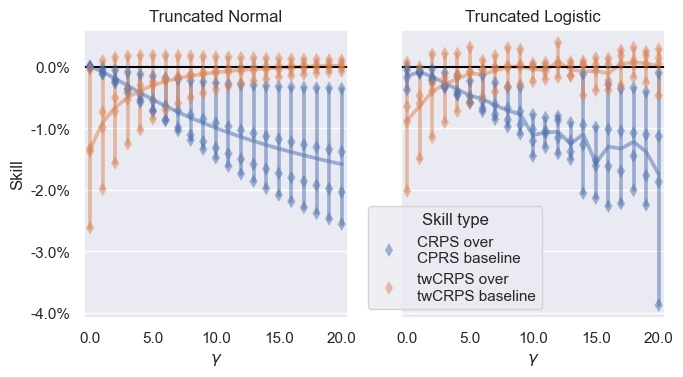

In [852]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7.5, 3.75), sharey = True, sharex = True)
sns.stripplot(
    x = "gamma",
    y = "value",
    hue = "variable",
    data = res_skill_norm_melted,
    ax = axs[0], 
    jitter = False,
    marker = "d",
    s = 7,
    #errorbar = full_range,
)
sns.pointplot(
    x = "gamma",
    y = "value",
    hue = "variable",
    data = res_skill_norm_melted,
    ax = axs[0], 
    markers = "none",
    errorbar = full_range,
    #linestyles = "none",
)
plt.setp(axs[0].collections, alpha=.5) #for the markers
plt.setp(axs[0].lines, alpha=.5)       #for the lines
axs[0].axhline(0, color = "black")
axs[0].set_xlabel(r'$\gamma$')
axs[0].set_ylabel("Skill")
axs[0].set_title("Truncated Normal")
axs[0].get_legend().remove()

sns.stripplot(
    x = "gamma",
    y = "value",
    hue = "variable",
    data = res_skill_logistic_melted,
    ax = axs[1], 
    jitter = False,
    marker = "d",
    s = 7,
    #errorbar = full_range,
)
sns.pointplot(
    x = "gamma",
    y = "value",
    hue = "variable",
    data = res_skill_logistic_melted,
    ax = axs[1], 
    markers = "none",
    errorbar = full_range,
    #linestyles = "none",
)
plt.setp(axs[1].collections, alpha=.5) #for the markers
plt.setp(axs[1].lines, alpha=.5)       #for the lines
axs[1].axhline(0, color = "black")
axs[1].set_xlabel(r'$\gamma$')
axs[1].set_ylabel("")
axs[1].set_title("Truncated Logistic")
axs[1].get_legend().remove()


plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%s%%'))
handles, labels = axs[0].get_legend_handles_labels()
labels = ["CRPS over\nCPRS baseline", "twCRPS over\ntwCRPS baseline"]
fig.legend(handles, labels, title = "Skill type", loc='upper center', bbox_to_anchor=(0.62, 0.43),fancybox=True, ncol = 1)
#fig.legend(title = "Skill type", loc="outside lower center", ncol=1
axs[0].set_xticks([0, 5, 10, 15, 20])
plt.savefig("plots/varying_gamma_twcrps_tr_norm_logistic.png", dpi=300, bbox_inches = "tight")



## Linear pool

In [134]:
def sample_crps(pred, true):
    diff_X_O = np.abs(pred - true).mean()
    diff_X_X = (scipy.spatial.distance.cdist(pred.swapaxes(-2, -1), pred.swapaxes(-2, -1), "minkowski", p = 1)/pred.shape[0]).mean()
    return diff_X_O - 0.5*diff_X_X

def sample_twcrps(pred, true, tau):
    pred = np.where(pred > tau, pred, tau)
    true = np.where(true > tau, true, tau)
    
    diff_X_O = np.abs(pred - true).mean()
    diff_X_X = (scipy.spatial.distance.cdist(pred.swapaxes(-2, -1), pred.swapaxes(-2, -1), "minkowski", p = 1)/pred.shape[0]).mean()
    return diff_X_O - 0.5*diff_X_X

def sample_tr_norm(mu, sigma, n_samples):
    mu, sigma = np.repeat(np.expand_dims(np.array(mu), -1), n_samples, -1), np.repeat(np.expand_dims(np.array(sigma), -1), n_samples, -1)
    
    q_0 = scipy.stats.norm.cdf(0, loc = mu, scale = sigma)
    quantiles = q_0 + np.random.rand(*mu.shape)*(1-q_0)
    
    return scipy.stats.norm.ppf(quantiles, loc = mu, scale = sigma)

def sample_crps_tr_norm(mu, sigma, y, n_samples):
    pred = sample_tr_norm(mu, sigma, n_samples)
    return sample_crps(pred, np.expand_dims(y, -1)).mean()

def sample_twcrps_tr_norm(mu, sigma, y, n_samples, tau = 0):
    pred = sample_tr_norm(mu, sigma, n_samples)
    return sample_twcrps(pred, np.expand_dims(y, -1), tau).mean()
def sample_tr_norm_mixture(mu, sigma, mu_tilde, sigma_tilde, n_samples, h = 1/2):
    pct_samples = np.random.binomial(n_samples, h)
    
    samples = sample_tr_norm(mu, sigma, pct_samples)
    samples_tilde = sample_tr_norm(mu_tilde, sigma_tilde, n_samples - pct_samples)
    return np.concatenate([samples, samples_tilde], axis = -1) #np.where(samples_tilde > combination_tau, samples_tilde, samples)

def sample_tr_norm_mixture_unequal(mu, sigma, mu_tilde, sigma_tilde, n_samples, combination_tau):
    samples = sample_tr_norm(mu, sigma, n_samples)
    samples_tilde = sample_tr_norm(mu_tilde, sigma_tilde, n_samples)
    return np.where(samples > combination_tau, samples_tilde, samples)

def sample_crps_tr_norm_mixture(mu, sigma, mu_tilde, sigma_tilde, y, n_samples, h = 1/2):
    pred = sample_tr_norm_mixture(mu, sigma, mu_tilde, sigma_tilde, n_samples, h)
    return sample_crps(pred, np.expand_dims(y, -1)).mean()

def sample_twcrps_tr_norm_mixture(mu, sigma, mu_tilde, sigma_tilde, y, n_samples, h = 1/2, tau = 0):
    pred = sample_tr_norm_mixture(mu, sigma, mu_tilde, sigma_tilde, n_samples, h)
    return sample_twcrps(pred, np.expand_dims(y, -1), tau).mean()

def logistic_quantile(p, loc, scale):
    return loc + scale * np.log(p/(1-p))

def logistic_cdf(x, loc, scale):
    return 1/(1+ np.exp(-(x-loc)/scale))

def sample_tr_logistic(mu, sigma, n_samples):
    mu, sigma = np.repeat(np.expand_dims(np.array(mu), -1), n_samples, -1), np.repeat(np.expand_dims(np.array(sigma), -1), n_samples, -1)
    
    q_0 = logistic_cdf(0, loc = mu, scale = sigma)
    quantiles = q_0 + np.random.rand(*mu.shape)*(1-q_0)
    
    return logistic_quantile(quantiles, loc = mu, scale = sigma)

def sample_crps_tr_logistic(mu, sigma, y, n_samples):
    pred = sample_tr_logistic(mu, sigma, n_samples)
    return sample_crps(pred, np.expand_dims(y, -1)).mean()

def sample_twcrps_tr_logistic(mu, sigma, y, n_samples, tau = 0):
    pred = sample_tr_logistic(mu, sigma, n_samples)
    return sample_twcrps(pred, np.expand_dims(y, -1), tau).mean()

def sample_tr_logistic_mixture(mu, sigma, mu_tilde, sigma_tilde, n_samples, h = 1/2):
    pct_samples = np.random.binomial(n_samples, h)
    
    samples = sample_tr_logistic(mu, sigma, pct_samples)
    samples_tilde = sample_tr_logistic(mu_tilde, sigma_tilde, n_samples - pct_samples)
    return np.concatenate([samples, samples_tilde], axis = -1) #np.where(samples_tilde > combination_tau, samples_tilde, samples)

def sample_crps_tr_logistic_mixture(mu, sigma, mu_tilde, sigma_tilde, y, n_samples, h = 1/2):
    pred = sample_tr_logistic_mixture(mu, sigma, mu_tilde, sigma_tilde, n_samples, h)
    return sample_crps(pred, np.expand_dims(y, -1)).mean()

def sample_twcrps_tr_logistic_mixture(mu, sigma, mu_tilde, sigma_tilde, y, n_samples, h = 1/2, tau = 0):
    pred = sample_tr_logistic_mixture(mu, sigma, mu_tilde, sigma_tilde, n_samples, h)
    return sample_twcrps(pred, np.expand_dims(y, -1), tau).mean()


In [136]:
def get_model_score_mixture(x, x_tilde, preds, y, score = sample_crps_tr_norm_mixture, *args, **kwargs):
    return score(*model(x, preds), *model(x_tilde, preds), y, *args, **kwargs).mean()

def get_model_score_eval_mixture(x, x_tilde, preds, y, score = tr_norm_CRPS, *args, **kwargs):
    if x is None:
        return np.nan
    return score(*model(x, preds), *model(x_tilde, preds), y, *args, **kwargs).mean()

In [138]:
res_norm = []
res_logistic = []

q_tau = 0.9

for cluster in tqdm(range(n_clusters)):

    locations = clusters[cluster]
    x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)

    # Define threshold
    tau = np.quantile(y_train, q_tau)
    
    # Get starting values like crch
    linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
    x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
    
    #### Experiments -- Truncated Normal ####
    
    # CRPS
    res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
        
    # twCRPS
    res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")

    # Mixture
    for h in np.linspace(0, 1, num = 11):
        crps = get_model_score_mixture(res_opt_crps.x, res_opt_twcrps.x, x_test, y_test, score = sample_crps_tr_norm_mixture, n_samples = 1000, h = h)
        twcrps = get_model_score_mixture(res_opt_crps.x, res_opt_twcrps.x, x_test, y_test, score = sample_twcrps_tr_norm_mixture, n_samples = 1000, tau = tau, h = h)
        res_norm.append(pd.DataFrame({
            "location": cluster,
            "forecast_period": forecast_period,
            "CRPS": crps,
            "twCRPS": twcrps,
            "quantile": q_tau,
            "h": h
        }, index = [0]))

    #### Experiments -- Truncated Logistic ####
    
    # CRPS
    res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_logistic_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
        
    # twCRPS
    res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_logistic_twCRPS, tau), exp = f"twCRPS finetune -- {cluster}, {forecast_period}")

    # Mixture
    for h in np.linspace(0, 1, num = 11):
        crps = get_model_score_mixture(res_opt_crps.x, res_opt_twcrps.x, x_test, y_test, score = sample_crps_tr_logistic_mixture, n_samples = 1000, h = h)
        twcrps = get_model_score_mixture(res_opt_crps.x, res_opt_twcrps.x, x_test, y_test, score = sample_twcrps_tr_logistic_mixture, n_samples = 1000, tau = tau, h = h)
        res_logistic.append(pd.DataFrame({
            "location": cluster,
            "forecast_period": forecast_period,
            "CRPS": crps,
            "twCRPS": twcrps,
            "quantile": q_tau,
            "h": h
        }, index = [0]))

res_norm = pd.concat(res_norm)
res_logistic = pd.concat(res_logistic)

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:15: RuntimeWarning:

divide by zero encountered in log

 25%|██▌       | 1/4 [47:18<2:21:54, 2838.31s/it]C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:6: RuntimeWarning:

divide by zero encountered in divide

C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning:

invalid value encountered in subtract

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:6: RuntimeWarning:

divide by zero encountered in divide

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:15: RuntimeWarning:

divide by zero encountered in divide

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\4072612730.py:15: RuntimeWarning:

divide by zero encountered in log

C:\Users\jw1301\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning:

invalid value encountered in subtract

C:\Users\j

In [139]:
res_norm.to_csv("results/linear_pool_tr_norm_all_quantiles.csv")
res_logistic.to_csv("results/linear_pool_tr_logistic_all_quantiles.csv")

In [854]:
res_norm = pd.read_csv("results/linear_pool_tr_norm_all_quantiles.csv")
res_logistic = pd.read_csv("results/linear_pool_tr_logistic_all_quantiles.csv")

In [856]:
# twCRPS model
res_norm_skill = res_norm.merge((res_norm[res_norm["h"] == 0.0]).rename(columns={"twCRPS":"twCRPS baseline"})[["location", "forecast_period", "quantile", "twCRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_logistic_skill =res_logistic.merge((res_logistic[res_logistic["h"] == 0.0]).rename(columns={"twCRPS":"twCRPS baseline"})[["location", "forecast_period", "quantile", "twCRPS baseline"]], on = ["location", "forecast_period", "quantile"])

# CRPS model
res_norm_skill = res_norm_skill.merge((res_norm[res_norm["h"] == 1.0]).rename(columns={"CRPS":"CRPS baseline"})[["location", "forecast_period", "quantile", "CRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_logistic_skill = res_logistic_skill.merge((res_logistic[res_logistic["h"] == 1.0]).rename(columns={"CRPS":"CRPS baseline"})[["location", "forecast_period", "quantile", "CRPS baseline"]], on = ["location", "forecast_period", "quantile"])

res_norm_skill["Skill - CRPS (%)"] = 100*(1 - res_norm_skill["CRPS"]/res_norm_skill["CRPS baseline"])
res_norm_skill["Skill - twCRPS (%)"] = 100*(1 - res_norm_skill["twCRPS"]/res_norm_skill["twCRPS baseline"])

res_logistic_skill["Skill - CRPS (%)"] = 100*(1 - res_logistic_skill["CRPS"]/res_logistic_skill["CRPS baseline"])
res_logistic_skill["Skill - twCRPS (%)"] = 100*(1 - res_logistic_skill["twCRPS"]/res_logistic_skill["twCRPS baseline"])

In [858]:
res_norm_skill_melted = res_norm_skill.melt(id_vars = ["h"], value_vars = ["Skill - CRPS (%)", "Skill - twCRPS (%)"])
res_norm_skill_melted.loc[res_norm_skill_melted["variable"] == "Skill - CRPS (%)", "variable"] = "CRPS over CPRS baseline"
res_norm_skill_melted.loc[res_norm_skill_melted["variable"] == "Skill - twCRPS (%)", "variable"] = "twCRPS over twCRPS baseline"

res_logistic_skill_melted = res_logistic_skill.melt(id_vars = ["h"], value_vars = ["Skill - CRPS (%)", "Skill - twCRPS (%)"])
res_logistic_skill_melted.loc[res_logistic_skill_melted["variable"] == "Skill - CRPS (%)", "variable"] = "CRPS over CPRS baseline"
res_logistic_skill_melted.loc[res_logistic_skill_melted["variable"] == "Skill - twCRPS (%)", "variable"] = "twCRPS over twCRPS baseline"

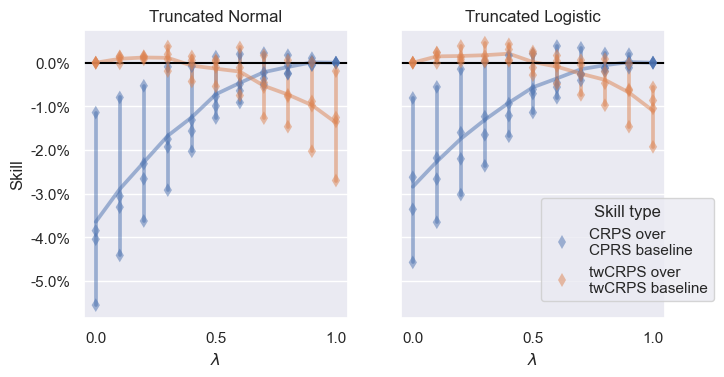

In [862]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7.5, 3.75), sharey = True, sharex = True)
sns.stripplot(
    x = "h",
    y = "value",
    hue = "variable",
    data = res_norm_skill_melted,
    ax = axs[0], 
    jitter = False,
    marker = "d",
    s = 7,
    #errorbar = full_range,
)
sns.pointplot(
    x = "h",
    y = "value",
    hue = "variable",
    data = res_norm_skill_melted,
    ax = axs[0], 
    markers = "none",
    errorbar = full_range,
    #linestyles = "none",
)
plt.setp(axs[0].collections, alpha=.5) #for the markers
plt.setp(axs[0].lines, alpha=.5)       #for the lines
axs[0].axhline(0, color = "black")
axs[0].set_xlabel(r'$\lambda$')
axs[0].set_ylabel("Skill")
axs[0].set_title("Truncated Normal")
axs[0].get_legend().remove()

sns.stripplot(
    x = "h",
    y = "value",
    hue = "variable",
    data = res_logistic_skill_melted,
    ax = axs[1], 
    jitter = False,
    marker = "d",
    s = 7,
    #errorbar = full_range,
)
sns.pointplot(
    x = "h",
    y = "value",
    hue = "variable",
    data = res_logistic_skill_melted,
    ax = axs[1], 
    markers = "none",
    errorbar = full_range,
    #linestyles = "none",
)
plt.setp(axs[1].collections, alpha=.5) #for the markers
plt.setp(axs[1].lines, alpha=.5)       #for the lines
axs[1].axhline(0, color = "black")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_title("Truncated Logistic")
axs[1].get_legend().remove()


plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%s%%'))
plt.xlabel(r'$\lambda$')
handles, labels = axs[0].get_legend_handles_labels()
labels = ["CRPS over\nCPRS baseline", "twCRPS over\ntwCRPS baseline"]
fig.legend(handles, labels, title = "Skill type", loc='upper center', bbox_to_anchor=(0.85, 0.45),fancybox=True, ncol = 1)
#fig.legend(title = "Skill type", loc="outside lower center", ncol=1
axs[0].set_xticks([0, 5, 10])
plt.savefig("plots/varying_h_twcrps_tr_norm_logistic.png", dpi=300, bbox_inches = "tight")



Example case:

In [864]:
res_norm_skill = res_norm.merge((res_norm[res_norm["h"] == 1.0]).rename(columns={"twCRPS":"twCRPS baseline", "CRPS":"CRPS baseline"})[["location", "forecast_period", "quantile", "twCRPS baseline", "CRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_norm_skill["Skill - CRPS (%)"] = 100*(1 - res_norm_skill["CRPS"]/res_norm_skill["CRPS baseline"])
res_norm_skill["Skill - twCRPS (%)"] = 100*(1 - res_norm_skill["twCRPS"]/res_norm_skill["twCRPS baseline"])
res_norm_skill_melted = res_norm_skill.melt(id_vars = ["h"], value_vars = ["Skill - CRPS (%)", "Skill - twCRPS (%)"])


C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\2323630916.py:30: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



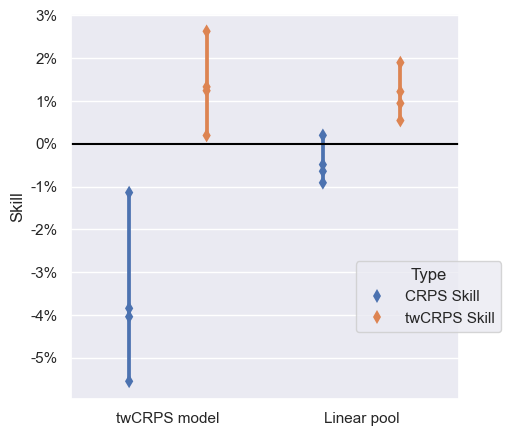

In [866]:
df = res_norm_skill_melted[(np.isclose(res_norm_skill_melted["h"], 0.6)) | (np.isclose(res_norm_skill_melted["h"], 0.))]


fig, axs = plt.subplots(figsize = (5,5))
sns.stripplot(
    y = "value",
    x = "h",
    hue = "variable",
    dodge = True,
    data = df,
    ax = axs,
    size = 7,
    jitter = False,
    marker = "d"
)
sns.pointplot(
    y = "value",
    x = "h",
    hue = "variable",
    data = df,
    ax = axs,
    markers = "none",
    dodge = .4,
    errorbar = full_range,
    linestyles = "none"
)
axs.axhline(0, color = "black")
axs.set_ylabel("Skill")
axs.set_xlabel("")
axs.set_xticklabels(["twCRPS model", "Linear pool"])
axs.get_legend().remove()

handles, labels = axs.get_legend_handles_labels()
#fig.legend(handles, labels, bbox_to_anchor=(0.6,0.28))
fig.legend(handles, ["CRPS Skill", "twCRPS Skill"], title = "Type", bbox_to_anchor=(1,0.4))

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
#plt.ylim(-15)

plt.savefig("plots/combination_crps_twcrps_norm_h_0_6.png", dpi=300, bbox_inches = "tight")

## Non proper losses

In [367]:
def sample_RMSE(mu, sigma, y, n_samples, tau):
    pred = sample_tr_norm(mu, sigma, n_samples)
    w = (y > tau)*1
    return np.mean(w*np.square(y - np.mean(pred, axis = -1)))


In [369]:
forecast_period = 48.0

res_norm = []

pit_vals = {"CRPS": [], "NP - CRPS": [], "HB": []}
losses = []


for q_tau in [0.9]:
    for cluster in range(n_clusters):
    
        locations = clusters[cluster]
        x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations, forecast_period) #get_data_mult_loc(data, locations = list(range(20)), forecast_period = forecast_period)
    
        # Define threshold
        tau = np.quantile(y_train, q_tau)
        
        # Get starting values like crch
        linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
        x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
        
        #### Experiments -- Truncated Normal ####
        
        # CRPS
        res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {cluster}, {forecast_period}")
        res_norm.append(get_eval_df("CRPS", res_opt_crps, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau))
        pit_vals["CRPS"].append(get_tr_norm_PIT(y_test, *model(res_opt_crps.x, x_test)))
        losses.append(pd.DataFrame({"training_q_tau": q_tau, "Model type": "CRPS", 
                                       "Brier score": get_model_score_eval(res_opt_crps.x, x_test, y_test, score = sample_brier_score, n_samples = 1000, tau = tau),
                                       "HB": get_model_score_eval(res_opt_crps.x, x_test, y_test, score = tr_norm_nonproper_CRPS_hess_boers, a = tau, b = y_train.std()), 
                                       "NP - CRPS": get_model_score_eval(res_opt_crps.x, x_test, y_test, score = tr_norm_nonproper_CRPS, tau = tau), 
                                       "NP - RMSE": get_model_score_eval(res_opt_crps.x, x_test, y_test, score = sample_RMSE, n_samples = 1000, tau = tau), 
                                       "location": cluster}, index = [0]))
            
        # Non-proper weighting
        res_opt, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_nonproper_CRPS, tau), exp = f"Non-proper treshold weighting -- {cluster}, {forecast_period}")
        res_norm.append(get_eval_df("Non-proper treshold weighting", res_opt, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau))
        pit_vals["NP - CRPS"].append(get_tr_norm_PIT(y_test, *model(res_opt.x, x_test)))
        losses.append(pd.DataFrame({"training_q_tau": q_tau, "Model type": "NP - CRPS", 
                                       "Brier score": get_model_score_eval(res_opt.x, x_test, y_test, score = sample_brier_score, n_samples = 1000, tau = tau),
                                       "HB": get_model_score_eval(res_opt.x, x_test, y_test, score = tr_norm_nonproper_CRPS_hess_boers, a = tau, b = y_train.std()), 
                                       "NP - CRPS": get_model_score_eval(res_opt.x, x_test, y_test, score = tr_norm_nonproper_CRPS, tau = tau), 
                                       "NP - RMSE": get_model_score_eval(res_opt.x, x_test, y_test, score = sample_RMSE, n_samples = 1000, tau = tau),
                                       "location": cluster}, index = [0]))

        # Non-proper Hess-Boers weighting
        res_opt, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_nonproper_CRPS_hess_boers, tau, y_train.std()), exp = f"Non-proper Hess-Boers -- {cluster}, {forecast_period}")
        res_norm.append(get_eval_df("Non-proper Hess-Boers", res_opt, x_test, y_test, tau, optim_meta, cluster, forecast_period, q_tau))
        pit_vals["HB"].append(get_tr_norm_PIT(y_test, *model(res_opt.x, x_test)))
        losses.append(pd.DataFrame({"training_q_tau": q_tau, "Model type": "HB", 
                                       "Brier score": get_model_score_eval(res_opt.x, x_test, y_test, score = sample_brier_score, n_samples = 1000, tau = tau),
                                       "HB": get_model_score_eval(res_opt.x, x_test, y_test, score = tr_norm_nonproper_CRPS_hess_boers, a = tau, b = y_train.std()), 
                                       "NP - CRPS": get_model_score_eval(res_opt.x, x_test, y_test, score = tr_norm_nonproper_CRPS, tau = tau), 
                                       "NP - RMSE": get_model_score_eval(res_opt.x, x_test, y_test, score = sample_RMSE, n_samples = 1000, tau = tau),
                                       "location": cluster}, index = [0]))


res_norm = pd.concat(res_norm)
losses = pd.concat(losses)

In [370]:
res_skill_norm = res_norm.merge((res_norm[res_norm["Model type"] == "CRPS"]).rename(columns={"CRPS":"CRPS baseline", "twCRPS":"twCRPS baseline"})[["location", "forecast_period", "quantile", "CRPS baseline", "twCRPS baseline"]], on = ["location", "forecast_period", "quantile"])
res_skill_norm = res_skill_norm[res_skill_norm["Model type"] != "CRPS"]

res_skill_norm["Skill - CRPS (%)"] = 100*(1 - res_skill_norm["CRPS"]/res_skill_norm["CRPS baseline"])
res_skill_norm["Skill - twCRPS (%)"] = 100*(1 - res_skill_norm["twCRPS"]/res_skill_norm["twCRPS baseline"])

res_skill_norm[res_skill_norm["Model type"] == "Non-proper Hess-Boers"]

Model type  location  forecast_period      CRPS    twCRPS  \
2   Non-proper Hess-Boers         0             48.0  0.852906  0.106827   
5   Non-proper Hess-Boers         1             48.0  1.415114  0.151069   
8   Non-proper Hess-Boers         2             48.0  0.949379  0.131285   
11  Non-proper Hess-Boers         3             48.0  1.823968  0.185398   

   optim  x0  quantile  CRPS baseline  twCRPS baseline  Skill - CRPS (%)  \
2   BFGS  x0       0.9       0.718703         0.102593        -18.672919   
5   BFGS  x0       0.9       1.104477         0.142286        -28.125275   
8   BFGS  x0       0.9       0.825895         0.126567        -14.951571   
11  BFGS  x0       0.9       1.394275         0.170913        -30.818349   

    Skill - twCRPS (%)  
2            -4.126560  
5            -6.172738  
8            -3.727765  
11           -8.475077

In [371]:
res_skill_norm[res_skill_norm["Model type"] == "Non-proper Hess-Boers"]["Skill - CRPS (%)"].mean()

-23.142028609971465

In [379]:
res_skill_losses = losses.merge((losses[losses["Model type"] == "CRPS"]).rename(columns={"HB":"HB baseline", "NP - CRPS":"NP - CRPS baseline", "NP - RMSE":"NP - RMSE baseline", "Brier score":"Brier score baseline"})[["location", "HB baseline", "NP - CRPS baseline", "NP - RMSE baseline", "Brier score baseline"]], on = ["location"])
res_skill_losses = res_skill_losses[res_skill_losses["Model type"] != "CRPS"]

res_skill_losses["Skill - HB (%)"] = 100*(1 - res_skill_losses["HB"]/res_skill_losses["HB baseline"])
res_skill_losses["Skill - NP - CRPS (%)"] = 100*(1 - res_skill_losses["NP - CRPS"]/res_skill_losses["NP - CRPS baseline"])
res_skill_losses["Skill - NP - RMSE (%)"] = 100*(1 - res_skill_losses["NP - CRPS"]/res_skill_losses["NP - RMSE baseline"])
res_skill_losses["Skill - Brier score (%)"] = 100*(1 - res_skill_losses["Brier score"]/res_skill_losses["Brier score baseline"])

res_skill_losses[res_skill_losses["Model type"] == "HB"]

training_q_tau Model type  Brier score        HB  NP - CRPS  NP - RMSE  \
2              0.9         HB     0.057943  0.258216   0.093657   0.343152   
5              0.9         HB     0.059306  0.399028   0.140784   0.740500   
8              0.9         HB     0.055248  0.315198   0.112746   0.474470   
11             0.9         HB     0.063770  0.534959   0.183823   1.155654   

    location  HB baseline  NP - CRPS baseline  NP - RMSE baseline  \
2          0     0.297596            0.131114            0.554620   
5          1     0.439665            0.194696            1.214271   
8          2     0.342386            0.146486            0.701168   
11         3     0.578451            0.248174            1.911876   

    Brier score baseline  Skill - HB (%)  Skill - NP - CRPS (%)  \
2               0.049954       13.232495              28.568009   
5               0.051202        9.242669              27.690467   
8               0.046432        7.940576              23.033009   
11              0.052577        7.518739              25.929838   

    Skill - NP - RMSE (%)  Skill - Brier score (%)  
2               83.113226               -15.992730  
5               88.405886               -15.828433  
8               83.920266               -18.986049  
11              90.385210               -21.289046

In [383]:
res_skill_losses[res_skill_losses["Model type"] == "HB"][["Skill - Brier score (%)", "Skill - HB (%)", "Skill - NP - CRPS (%)", "Skill - NP - RMSE (%)"]].mean()

Skill - Brier score (%)   -18.024064
Skill - HB (%)              9.483620
Skill - NP - CRPS (%)      26.305331
Skill - NP - RMSE (%)      86.456147
dtype: float64

In [311]:
PIT_values_df = pd.DataFrame({k: np.concatenate(e) for k, e in pit_vals.items()}).melt()
PIT_values_df = PIT_values_df[PIT_values_df["variable"].isin(["CRPS", "HB", ])]
PIT_values_df.loc[PIT_values_df["variable"] == "HB", "variable"] = "Non-proper Hess-Boers"


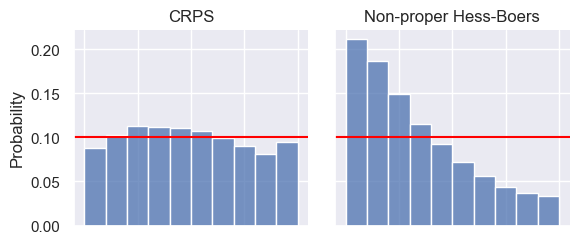

In [313]:
g = sns.FacetGrid(PIT_values_df, col="variable")
g.map(sns.histplot, "value", stat = "probability", bins = 10)
g.set_titles('{col_name}')
for ax in g.axes_dict.values():
    ax.axhline(0.1, color = "red")
    ax.set(xticklabels=[], xlabel=None)
#g.set(ylabel = "Frequency")
plt.savefig("plots/pit_hess_boers_crps.png", dpi=300, bbox_inches = "tight")


## Increasing number of clusters

In [295]:
forecast_period = 48.0

res = []

for q_tau in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for nr_of_locations in np.arange(1, 21):
    
        skill = []
    
        for _ in tqdm(range(50)):
            
            locations = np.random.choice(list(range(124)), size = nr_of_locations, replace = False)
                                         
            x_train, y_train, x_test, y_test = get_data_mult_loc(data, locations = locations, forecast_period = forecast_period)
        
            # Define threshold
            tau = np.quantile(y_train, q_tau)
            
            # Get starting values like crch
            linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
            x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
        
            #### Experiments ####
            
            # CRPS
            res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {location}, {forecast_period}")
            
            # twCRPS
            res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {location}, {forecast_period}")
        
            skill.append(
                100*(1 - tr_norm_twCRPS(*model(res_opt_twcrps.x, x_test), y_test, tau = tau).mean()/tr_norm_twCRPS(*model(res_opt_crps.x, x_test), y_test, tau = tau).mean())
            )
        res.append(
            pd.DataFrame({"Skill": skill, "Number of locations": nr_of_locations, "Training quantile": q_tau})
        )

res = pd.concat(res)
res.to_csv("results/increasing_number_of_stations_multiple_thresholds.csv")

 88%|████████▊ | 44/50 [00:31<00:04,  1.50it/s]C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:6: RuntimeWarning: invalid value encountered in divide
  return sigma*(z*(2*(Phi(z)-Phi(alpha))/(1-Phi(alpha)) -1) + 2*phi(z)/(1-Phi(alpha)) - 1/np.sqrt(np.pi) * (1-Phi(np.sqrt(2)*alpha))/np.square(1-Phi(alpha)))
C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:3: RuntimeWarning: divide by zero encountered in divide
  s = -mu/sigma
C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:3: RuntimeWarning: overflow encountered in divide
  s = -mu/sigma
C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:4: RuntimeWarning: divide by zero encountered in divide
  alpha = -mu/sigma
C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:4: RuntimeWarning: overflow encountered in divide
  alpha = -mu/sigma
C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:5: RuntimeWarning: divide by zero encountered in divide
  z = (y - mu)/s

Reduce training data size

In [298]:
def get_data_mult_loc_reduced_training_data(data, locations, forecast_period = 48):
    data_one_loc = data[(data.location.isin(locations)) & (data.forecast_period == forecast_period)]
    
    data_train = data_one_loc[data_one_loc.prediction_time.dt.year == 2020]
    data_test = data_one_loc[data_one_loc.prediction_time.dt.year >= 2021]

    x_train, y_train = data_train[["ensemble_mean", "ensemble_sd", "doy_sin", "doy_cos"]].values, data_train["observation"].values
    x_test, y_test = data_test[["ensemble_mean", "ensemble_sd", "doy_sin", "doy_cos"]].values, data_test["observation"].values
    
    return x_train, y_train, x_test, y_test

In [299]:
forecast_period = 48.0

res = []

for q_tau in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for nr_of_locations in np.arange(1, 21):
    
        skill = []
    
        for _ in tqdm(range(50)):
            
            locations = np.random.choice(list(range(124)), size = nr_of_locations, replace = False)
                                         
            x_train, y_train, x_test, y_test = get_data_mult_loc_reduced_training_data(data, locations = locations, forecast_period = forecast_period)
        
            # Define threshold
            tau = np.quantile(y_train, q_tau)
            
            # Get starting values like crch
            linear_regression = LinearRegression().fit(x_train[:, [0, 2, 3]], y_train)
            x0 = np.array([linear_regression.intercept_, *linear_regression.coef_, np.log(np.square(linear_regression.predict(x_train[:, [0, 2, 3]])-y_train).std()), 0, 0, 0]) #x0 = np.array([0,1,0,1])#np.random.rand(4)*2
        
            #### Experiments ####
            
            # CRPS
            res_opt_crps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_CRPS), exp = f"CRPS -- {location}, {forecast_period}")
            
            # twCRPS
            res_opt_twcrps, optim_meta = do_optim(fun = get_model_score, x0 = x0, args = (x_train, y_train, tr_norm_twCRPS, tau), exp = f"twCRPS finetune -- {location}, {forecast_period}")
        
            skill.append(
                100*(1 - tr_norm_twCRPS(*model(res_opt_twcrps.x, x_test), y_test, tau = tau).mean()/tr_norm_twCRPS(*model(res_opt_crps.x, x_test), y_test, tau = tau).mean())
            )
        res.append(
            pd.DataFrame({"Skill": skill, "Number of locations": nr_of_locations, "Training quantile": q_tau})
        )

res = pd.concat(res)

 62%|██████▏   | 31/50 [00:18<00:10,  1.81it/s]C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:14: RuntimeWarning: invalid value encountered in divide
  twcrps_y_leq_tau = sigma * (-s*np.square((1-Phi(s))/(1-Phi(alpha))) + 2*phi(s) * (1-Phi(s))/np.square(1-Phi(alpha)) - 1/np.sqrt(np.pi) * (1-Phi(np.sqrt(2)*s))/np.square(1-Phi(alpha)))
C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:15: RuntimeWarning: invalid value encountered in divide
  twcrps_y_gre_tau = sigma*(-s*np.square((Phi(s)-Phi(alpha))/(1-Phi(alpha))) + z*(2*(Phi(z)-Phi(alpha))/(1-Phi(alpha)) -1) + 2/(1-Phi(alpha)) * (phi(z) - phi(s) * (Phi(s) - Phi(alpha))/(1-Phi(alpha))) - 1/np.sqrt(np.pi) * (1-Phi(np.sqrt(2)*s))/np.square(1-Phi(alpha)))
C:\Users\jw1301\AppData\Local\Temp\ipykernel_2500\2742833331.py:15: RuntimeWarning: divide by zero encountered in divide
  twcrps_y_gre_tau = sigma*(-s*np.square((Phi(s)-Phi(alpha))/(1-Phi(alpha))) + z*(2*(Phi(z)-Phi(alpha))/(1-Phi(alpha)) -1) + 2/(1-Phi(alp

In [306]:
res = res.reset_index()

In [332]:
res.to_csv("results/increasing_number_of_stations_multiple_thresholds_half_the_training_data.csv")

In [64]:
res = pd.read_csv("results/increasing_number_of_stations_multiple_thresholds.csv")
res["Training quantile (str)"] = res["Training quantile"].astype(str) + " -- Full training data"
res_half_training_data = pd.read_csv("results/increasing_number_of_stations_multiple_thresholds_half_the_training_data.csv")
res_half_training_data["Training quantile (str)"] = res_half_training_data["Training quantile"].astype(str) + " -- Half the training data"

res = pd.concat([res, res_half_training_data])
res = res.reset_index()

In [868]:
res = pd.read_csv("results/increasing_number_of_stations_multiple_thresholds.csv")
res["Training data size"] = "Full training data"
res_half_training_data = pd.read_csv("results/increasing_number_of_stations_multiple_thresholds_half_the_training_data.csv")
res_half_training_data["Training data size"] = "One year of training data"

res = pd.concat([res, res_half_training_data])
res = res.reset_index()

C:\Users\jw1301\AppData\Local\Temp\ipykernel_19412\2425277782.py:4: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



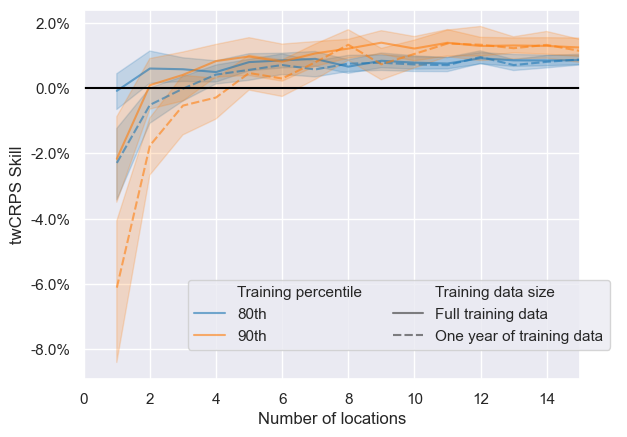

In [870]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots() 
sns.lineplot(res[res["Training quantile"].isin([0.8, 0.9])], x = "Number of locations", y = "Skill",  hue = "Training quantile", style = "Training data size", palette = sns.color_palette("tab10"), err_style = "band", alpha = 0.6, ax = ax)
plt.xticks(range(0, 16, 2))
plt.axhline(0, color = "black")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%s%%'))
plt.ylabel("twCRPS Skill")
plt.xlim(0,15)

h,l = ax.get_legend_handles_labels()
l = ["Training percentile", "80th", "90th", "Training data size", *l[4:]]
ax.legend_.remove()
fig.legend(h,l, ncol=2, loc = (0.3, 0.2)) # you can specify any location parameter you want here
plt.savefig("plots/training_data_dependence_varying_data_varying_quantile.png", dpi=300, bbox_inches = "tight")
